<a href="https://colab.research.google.com/github/lkhart/kaggle_house_prices/blob/main/house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [122]:
train_df = pd.read_csv('train.csv')

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# **House Price Exploratory Data Analysis**
#### [Kaggle Competition Entry](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description)/Class Assignment 
#### Laura Hart - MSDS 422 - Winter 2022

The objective of this exercise is to predict sale price of homes in Ames, Iowa given the available training data. First, we conduct an exploratory analysis of the provided data to understand distributions, begin identifying potential predictors of sale price, and explore transformations and feature creation that will prepare the data for modeling.

## **Understanding SalePrice Distribution**

By reviewing the descriptive statistics and visualizations generated here, we're able to understand the distribution of SalePrice among Ames homes. The median home SalePrice is \$163,000, while the average home SalePrice is \$180,921. This tells us that the distribution of SalePrice is right-skewed, which can be seen in the histogram below. Finally, we see that while there are homes with SalePrice > \$350,000 and up to $755,000, these homes are considered outliers within our dataset.

In [4]:
# basic descriptive stats on SalePrice Distribution
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

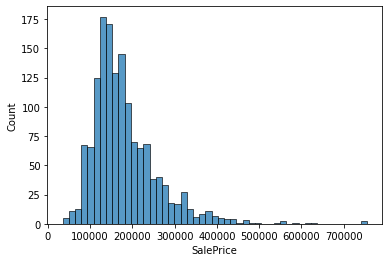

In [ ]:
# histogram
sns.histplot(x='SalePrice', data=train_df).set_title=('SalePrice Distribution')

Text(0.5, 1.0, 'SalePrice Distribution')

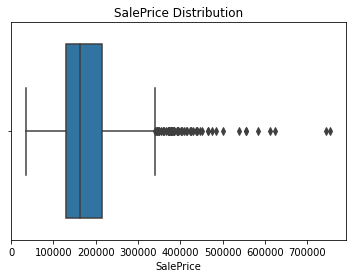

In [ ]:
# boxplot
sns.boxplot(x='SalePrice', data=train_df).set_title('SalePrice Distribution')

## **Missing Data and Outliers**

The Kaggle files included a .txt file with descriptions of each column and definitions of categorical variable values. When dealing with missing values, we'll have to consider the context to determine whether the NA should be replaced (with a 0 or 'None', for example) or imputed.

Most columns appear to have data entered for all or most rows, but we do see null values in both categorical and quantitative variables within the dataset:

In [ ]:
# get counts of NA values
ct_na = train_df.isna().sum().sort_values(ascending=False)
ct_na[ct_na > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

For many of those columns that are categorical variables and contain 'NA' values, the 'NA' value indicates that the category does not apply. For example, PoolQC is a categorical variable indicating pool quality, and a value of 'NA' indicates that the house does not have a pool. In these cases, I will replace the 'NA' values with 'None'. This modification will apply to:


*   PoolQC
*   MiscFeature
*   Alley
*   Fence
*   FireplaceQu
*   GarageCond
*   GarageType
*   GarageYrBlt
*   GarageFinish
*   GarageQual
*   BsmtExposure
*   BsmtFinType2
*   BsmtFinType1
*   BsmtCond
*   BsmtQual
*   MasVnrType




In [123]:
train_df.PoolQC.fillna('None', inplace=True)
train_df.MiscFeature.fillna('None', inplace=True)
train_df.Alley.fillna('None', inplace=True)
train_df.Fence.fillna('None', inplace=True)
train_df.FireplaceQu.fillna('None', inplace=True)
train_df.GarageCond.fillna('None', inplace=True)
train_df.GarageType.fillna('None', inplace=True)
train_df.GarageYrBlt.fillna('None', inplace=True)
train_df.GarageFinish.fillna('None', inplace=True)
train_df.GarageQual.fillna('None', inplace=True)
train_df.BsmtExposure.fillna('None', inplace=True)
train_df.BsmtFinType2.fillna('None', inplace=True)
train_df.BsmtFinType1.fillna('None', inplace=True)
train_df.BsmtCond.fillna('None', inplace=True)
train_df.BsmtQual.fillna('None', inplace=True)
train_df.MasVnrType.fillna('None', inplace=True)


For the categorical column 'Electrical', there shouldn't be an option for a house to not have a category applied. Because there is only 1 case where Electrical is NA, we will replace this NA with the most common Electrical type.

In [ ]:
# see how common each Electrical value is
train_df['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [124]:
# replace Electrical = NA with most common Electrical value
train_df.Electrical.fillna(train_df.Electrical.mode()[0], inplace=True)

For those columns that are quantitative variables and contain 'NA' values, we must determine whether the 'NA' can be replaced with a 0, imputed from other information, or if the column needs to be dropped from the dataset if not applicable to most observations.

NA values for LotFrontage should not necessarily be replaced with 0, as this value may be missing but not equal to 0. Let's look at the distribution of LotFrontage:



In [ ]:
# basic descriptive stats on LotFrontage Distribution
train_df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [195]:
# basic descriptive stats on LotFrontage distribution by Neighborhood
train_df['LotFrontage'].groupby(train_df['Neighborhood']).describe()

,count,mean,std,min,25%,50%,75%,max
Neighborhood,,,,,,,,
Blmngtn,14.0,47.142857,4.990100,43.0,43.00,43.0,53.00,53.0
Blueste,2.0,24.000000,0.000000,24.0,24.00,24.0,24.00,24.0
BrDale,16.0,21.562500,1.209339,21.0,21.00,21.0,21.00,24.0
BrkSide,51.0,57.509804,15.528519,50.0,50.00,52.0,60.00,144.0
ClearCr,13.0,83.461538,18.875096,62.0,75.00,80.0,83.00,138.0
CollgCr,126.0,71.682540,16.359291,36.0,64.00,70.0,78.00,122.0
Crawfor,41.0,71.804878,19.436074,40.0,55.00,74.0,82.00,130.0
Edwards,92.0,68.217391,32.431780,24.0,58.75,65.5,74.25,313.0
Gilbert,49.0,79.877551,32.748176,42.0,60.00,65.0,93.00,182.0


The median value of LotFrontage appears to vary by Neighborhood. To deal with NA values in LotFrontage, we will impute the LotFrontage value by applying the median LotFrontage value among homes in the same Neighborhood.

In [125]:
# replace LotFrontage = NA with median LotFrontage for associated Neighborhood
train_df.LotFrontage = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

NA values for MasVnrArea apply to the same rows that had an NA value for MasVnrType; as seen below, a value of 0 for MasVnrArea is most common, and therefore we can comfortably replace the NA MasVnrArea values with 0.

In [ ]:
# basic descriptive stats on MasVnrArea Distribution
train_df['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [126]:
train_df.MasVnrArea.fillna(0, inplace=True)

In [127]:
# confirm that all NA values have been addressed
# get counts of NA values
ct_na = train_df.isna().sum().sort_values(ascending=False)
ct_na[ct_na > 0]

Series([], dtype: int64)

Next, I'm looking at the quantitative variables to identify any outliers. Depending on the appearance of a quantitative variable's distribution, I may choose to drop outliers, apply a transformation to the variable's distribution*, or create a categorical variable by binning ranges of a quantitative variable (ex. if there is a clear bimodal distribution). I will make these changes in the next phase, after the exploratory analysis (for now just getting an idea of distributions).

*Transforming the variable distribution would only be necessary for certain types of modeling techniques. Right now, I'm leaning toward a linear regression approach for modeling this data, and normalization would be needed. I will circle back and nix this part if I decide to apply a technique that does not require normalization (such as random forest).

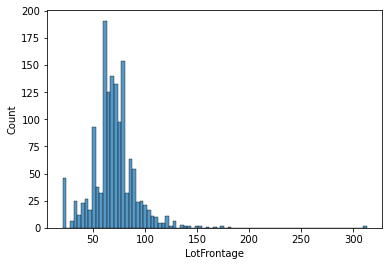

In [ ]:
# histogram
sns.histplot(x='LotFrontage', data=train_df).set_title=('LotFrontage Distribution')

# lot frontage resembles a normal distribution, with some outliers on the higher end. this variable will need to be normalized.

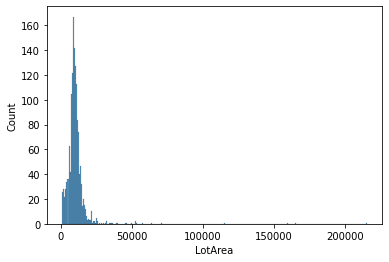

In [ ]:
# histogram
sns.histplot(x='LotArea', data=train_df).set_title=('LotArea Distribution')

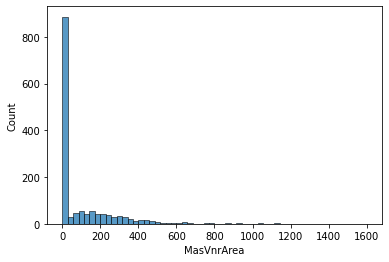

In [ ]:
# histogram
sns.histplot(x='MasVnrArea', data=train_df).set_title=('MasVnrArea Distribution')

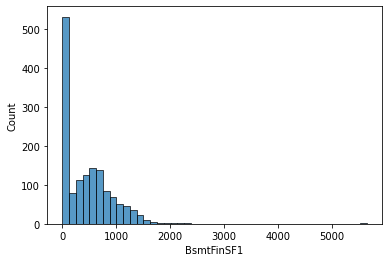

In [ ]:
# histogram
sns.histplot(x='BsmtFinSF1', data=train_df).set_title=('BsmtFinSF1 Distribution')

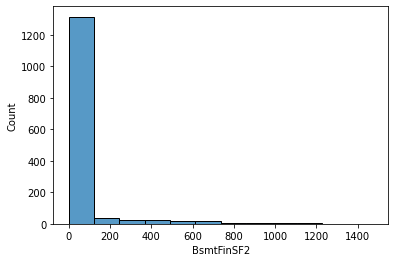

In [ ]:
# histogram
sns.histplot(x='BsmtFinSF2', data=train_df).set_title=('BsmtFinSF2 Distribution')

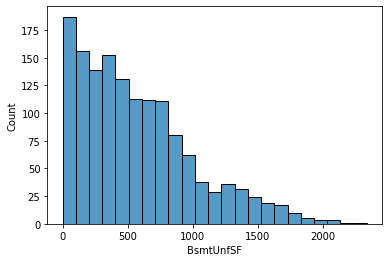

In [ ]:
# histogram
sns.histplot(x='BsmtUnfSF', data=train_df).set_title=('BsmtUnfSF Distribution')

# this variable is a good example of one that has a skewed distribution, and I will handle this by applying a log/power transformation.

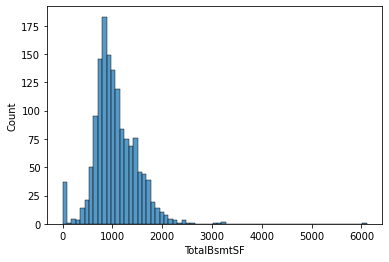

In [ ]:
# histogram
sns.histplot(x='TotalBsmtSF', data=train_df).set_title=('TotalBsmtSF Distribution')

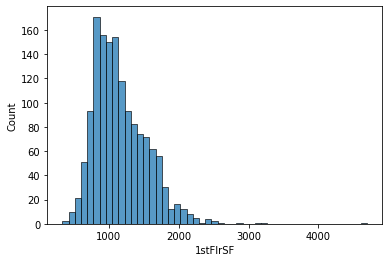

In [ ]:
# histogram
sns.histplot(x='1stFlrSF', data=train_df).set_title=('1stFlrSF Distribution')

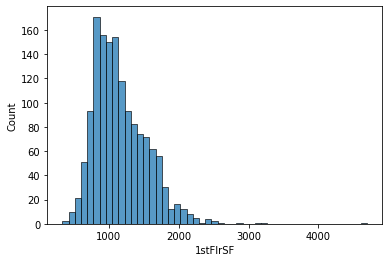

In [ ]:
# histogram
sns.histplot(x='1stFlrSF', data=train_df).set_title=('1stFlrSF Distribution')

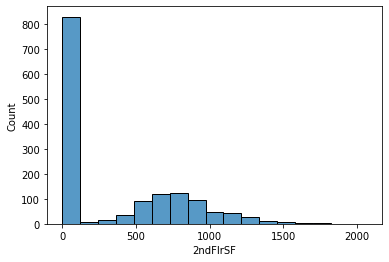

In [ ]:
# histogram
sns.histplot(x='2ndFlrSF', data=train_df).set_title=('2ndFlrSF Distribution')

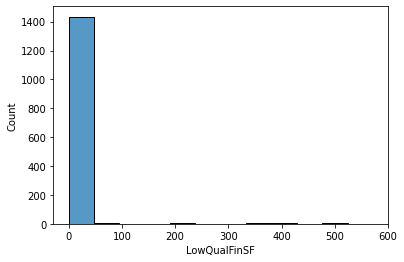

In [ ]:
# histogram
sns.histplot(x='LowQualFinSF', data=train_df).set_title=('LowQualFinSF Distribution')

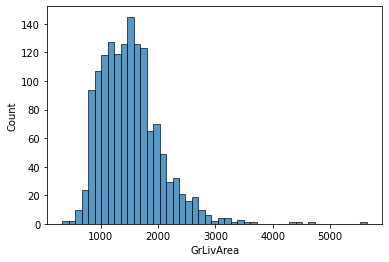

In [ ]:
# histogram
sns.histplot(x='GrLivArea', data=train_df).set_title=('GrLivArea Distribution')

# another good candidate for normalization - shape resembles normal distribution (with some right skewness)

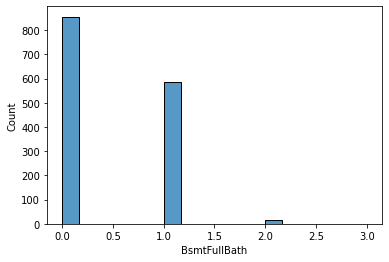

In [ ]:
# histogram
sns.histplot(x='BsmtFullBath', data=train_df).set_title=('BsmtFullBath Distribution')

# discrete quantitative variables like this and other bedroom/bathroom counts may make for better categorical variables

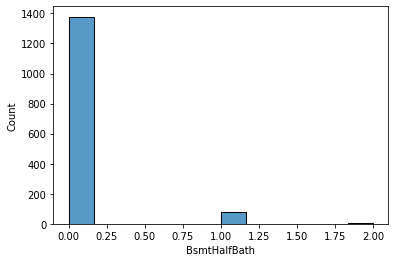

In [ ]:
# histogram
sns.histplot(x='BsmtHalfBath', data=train_df).set_title=('BsmtHlafBath Distribution')

# discrete quantitative variables like this and other bedroom/bathroom counts may make for better categorical variables

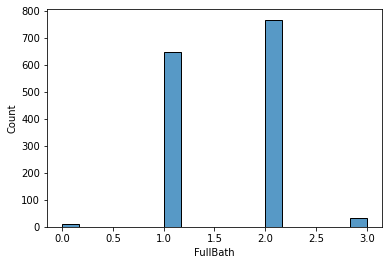

In [ ]:
# histogram
sns.histplot(x='FullBath', data=train_df).set_title=('FullBath Distribution')

# discrete quantitative variables like this and other bedroom/bathroom counts may make for better categorical variables

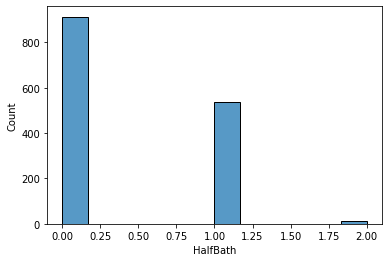

In [ ]:
# histogram
sns.histplot(x='HalfBath', data=train_df).set_title=('HalfBath Distribution')

# discrete quantitative variables like this and other bedroom/bathroom counts may make for better categorical variables

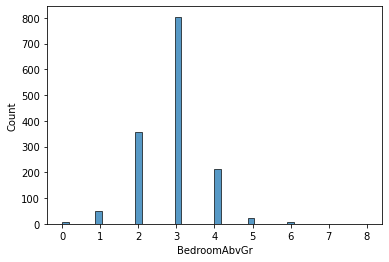

In [ ]:
# histogram
sns.histplot(x='BedroomAbvGr', data=train_df).set_title=('BedroomAvbGr Distribution')

# discrete quantitative variables like this and other bedroom/bathroom counts may make for better categorical variables

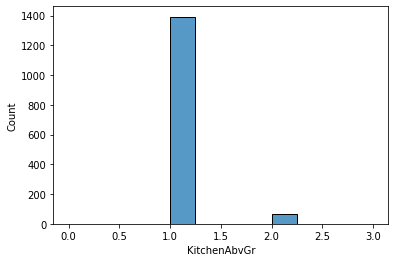

In [ ]:
# histogram
sns.histplot(x='BsmtFullBath', data=train_df).set_title=('BsmtFullBath Distribution')

# discrete quantitative variables like this and other bedroom/bathroom counts may make for better categorical variables

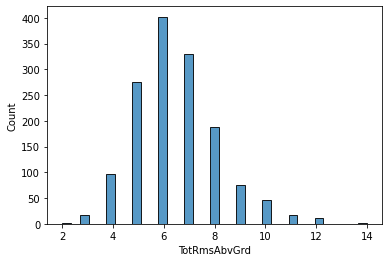

In [ ]:
# histogram
sns.histplot(x='TotRmsAbvGrd', data=train_df).set_title=('TotRmsAbvGrd Distribution')

# discrete quantitative variables like this and other bedroom/bathroom counts may make for better categorical variables

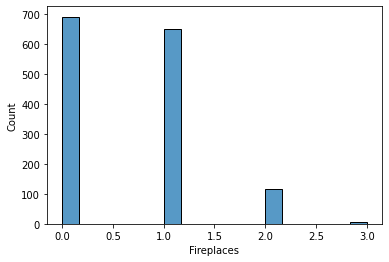

In [ ]:
# histogram
sns.histplot(x='Fireplaces', data=train_df).set_title=('Fireplaces Distribution')

# discrete quantitative variables like this and other bedroom/bathroom counts may make for better categorical variables

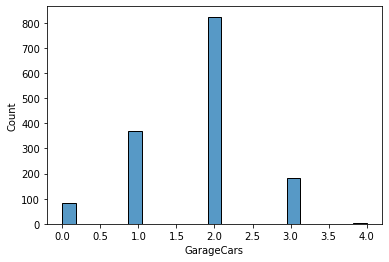

In [ ]:
# histogram
sns.histplot(x='GarageCars', data=train_df).set_title=('GarageCars Distribution')

# discrete quantitative variables like this and other bedroom/bathroom counts may make for better categorical variables

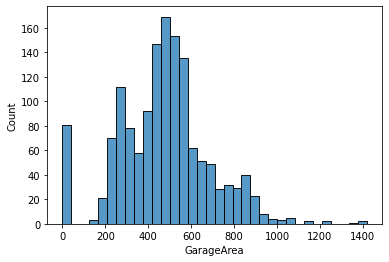

In [ ]:
# histogram
sns.histplot(x='GarageArea', data=train_df).set_title=('GarageArea Distribution')

## **Potential Predictors of SalePrice**

Initially, I want to look at 3 variables which I would expect to have a strong relationship with our dependent variable, SalePrice. Looking at the actual relationships between these variables and SalePrice will help me understand whether they may act as strong predictors of the SalePrice value.
Potential predictors:

*   GrLivArea - above ground living area in square feet
*   Neighborhood - neighborhood in Ames, IA
*   OverallCond - overall condition of the house (rating 1-10)





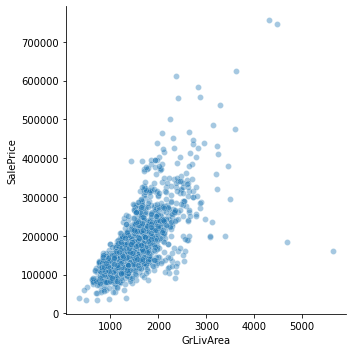

In [10]:
# scatter plot showing relationship between GrLivArea and SalePrice
sns.relplot(x='GrLivArea', y='SalePrice', kind='scatter', alpha=0.4, data=train_df).set_title=('SalePrice by GrLivArea')

As seen above, there appears to be a strong positive, linear relationship between GrLivArea and SalePrice. There appear to be a few exceptions to this relationship, notably the two points in the bottom right corner of the plot, but otherwise most points tend to follow the trend of a positive correlation.

For modeling purposes, I will remove the homes with > 4000 GrLivArea values:

In [128]:
train_df = train_df[train_df['GrLivArea'] < 4000]

[Text(0, 0, 'CollgCr'),
 Text(0, 0, 'Veenker'),
 Text(0, 0, 'Crawfor'),
 Text(0, 0, 'NoRidge'),
 Text(0, 0, 'Mitchel'),
 Text(0, 0, 'Somerst'),
 Text(0, 0, 'NWAmes'),
 Text(0, 0, 'OldTown'),
 Text(0, 0, 'BrkSide'),
 Text(0, 0, 'Sawyer'),
 Text(0, 0, 'NridgHt'),
 Text(0, 0, 'NAmes'),
 Text(0, 0, 'SawyerW'),
 Text(0, 0, 'IDOTRR'),
 Text(0, 0, 'MeadowV'),
 Text(0, 0, 'Edwards'),
 Text(0, 0, 'Timber'),
 Text(0, 0, 'Gilbert'),
 Text(0, 0, 'StoneBr'),
 Text(0, 0, 'ClearCr'),
 Text(0, 0, 'NPkVill'),
 Text(0, 0, 'Blmngtn'),
 Text(0, 0, 'BrDale'),
 Text(0, 0, 'SWISU'),
 Text(0, 0, 'Blueste')]

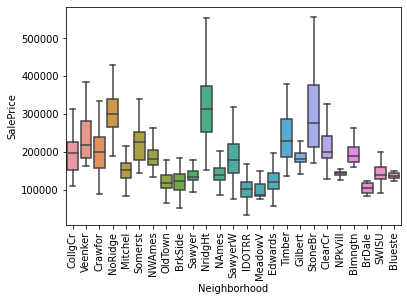

In [ ]:
# boxplots of SalePrice for each neighborhood
ax = sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

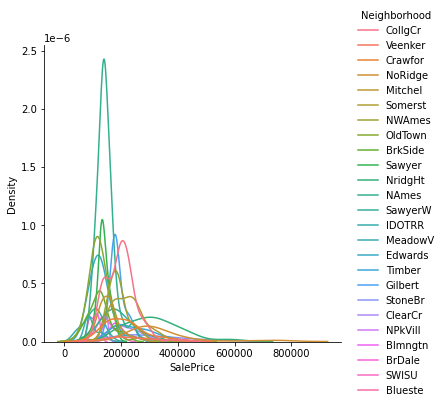

In [ ]:
# density plot of SalePrice colored by Neighborhood
sns.displot(x='SalePrice', hue='Neighborhood', data=train_df, kind='kde')

As represented in the two plots above, the distribution of SalePrice does have some variation across neighborhoods. Notably, NridgHt and StoneBr appear to include higher price homes in their distribution than most other neighborhoods (excluding outliers), and neighborhoods like NPkVill and Blueste appear to have more limited SalePrice ranges within them. These insights suggest that neighborhood may have value as a predictor of SalePrice.

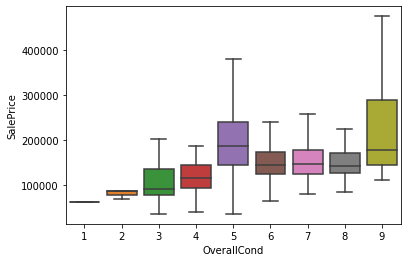

In [ ]:
# boxplots of SalePrice by OverallCond
sns.boxplot(x='OverallCond', y='SalePrice', data=train_df, showfliers=False)

Among lower values of OverallCond (which is a ranked categorical variable), we see that median SalePrice tends to increase with each increase in OverallCond. Notably, OverallCond=5 has the highest median SalePrice, and OverallCond values above 5 tend to remain fairly steady, with the exception of 9, which includes a broad range above its 50th percentile. All things considered, this variable may not be as effective of a predictor as I thought it would be; perhaps binning the OverallCond values (ex. OverallCond <=4 vs. >4) would make this variable more valuable for modeling. 

## **Feature Engineering**

Several of our quantitative variables actually suggest that a categorical variable should exist to indicate whether or not a home feature is present. These variables include:


*   PoolArea - whether or not home has pool
*   2ndFlrSF - whether or not home has a 2nd floor
*   GarageArea - whether or not home has a garage
*   TotalBsmtSF - whether or not home has a basement
*   Fireplaces - whether or not home has a fireplace

(other variables may also be used to indicate whether a given home feature is present, but these are all quantitative).

For each of these variables, I will create a new binary variable that equals 1 when the home feature is present (measurement value > 0) and 0 when that feature is absent (measurement value = 0).

Some variables, such as YearBuilt, offer an opportunity to bin ranges of years to create new categorical variables. I will perform that here.

Finally, I will go through each individual variable to determine if its current form is ready for modeling, or if I will alter or drop the variable before modeling.


In [130]:
# add each new binary variable to train_df

train_df['HasPool'] = np.where(train_df['PoolArea'] == 0, '0', '1')
train_df['Has2ndFlr'] = np.where(train_df['2ndFlrSF'] == 0, '0', '1')
train_df['HasGarage'] = np.where(train_df['GarageArea'] == 0, '0', '1')
train_df['HasBasement'] = np.where(train_df['TotalBsmtSF'] == 0, '0', '1')
train_df['HasFireplace'] = np.where(train_df['Fireplaces'] == 0, '0', '1')

For each of these new variables, I will generate a boxplot to visualize whether the presence of a given home feature is related to SalePrice distribution:

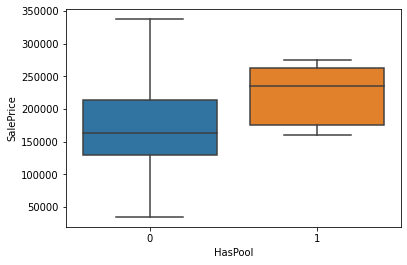

In [ ]:
# boxplots of SalePrice by HasPool
sns.boxplot(x='HasPool', y='SalePrice', data=train_df, showfliers=False)

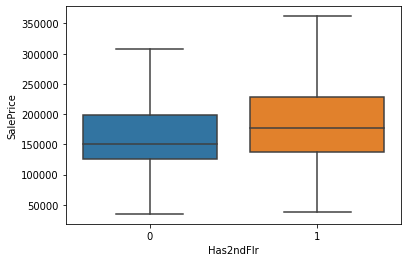

In [ ]:
# boxplots of SalePrice by Has2ndFlr
sns.boxplot(x='Has2ndFlr', y='SalePrice', data=train_df, showfliers=False)

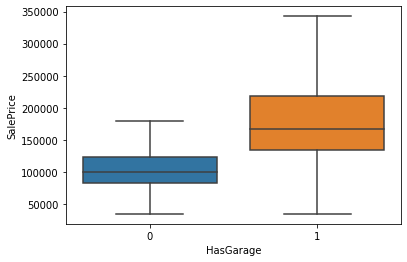

In [ ]:
# boxplots of SalePrice by HasGarage
sns.boxplot(x='HasGarage', y='SalePrice', data=train_df, showfliers=False)

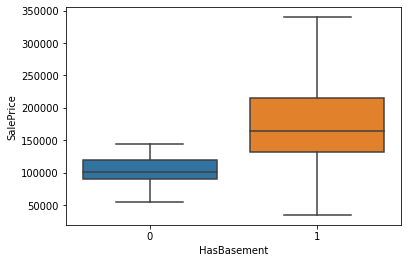

In [ ]:
# boxplots of SalePrice by HasBasement
sns.boxplot(x='HasBasement', y='SalePrice', data=train_df, showfliers=False)

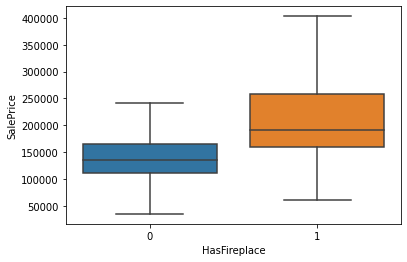

In [ ]:
# boxplots of SalePrice by HasFireplace
sns.boxplot(x='HasFireplace', y='SalePrice', data=train_df, showfliers=False)

As seen above, the presence of a pool, garage, basement, or fireplace appears to positively differentiate the home's SalePrice distribution from that of homes that do not have those features, respectively. The presence of a 2nd floor does not appear to differentiate SalePrice distribution from homes which do not have a 2nd floor. 

In [131]:
# drop Has2ndFlr
train_df = train_df.drop(['Has2ndFlr'], axis = 1)

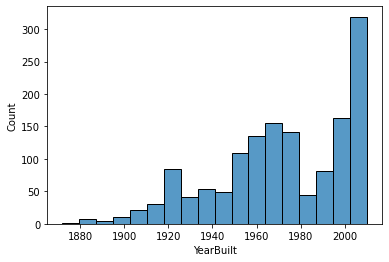

In [20]:
# histogram
sns.histplot(x='YearBuilt', data=train_df)

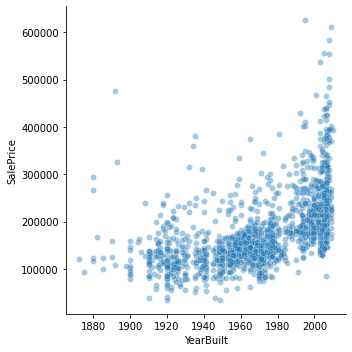

In [133]:
# YearBuilt
sns.relplot(x='YearBuilt', y='SalePrice', kind='scatter', alpha=0.4, data=train_df)

In [136]:
# year built could be a categorical variable with binned ranges

# function to bin years
def get_year_built_bin(YearBuilt):
  if YearBuilt < 1960:
    return 'pre-1960'

  elif YearBuilt < 1980:
    return '1960-79'

  elif YearBuilt < 2000:
    return '1980-1999'

  elif YearBuilt < 2006:
    return '2000-2005'
  
  else:
    return '2005 or later'


train_df['YearBuiltBin'] = train_df['YearBuilt'].apply(get_year_built_bin)

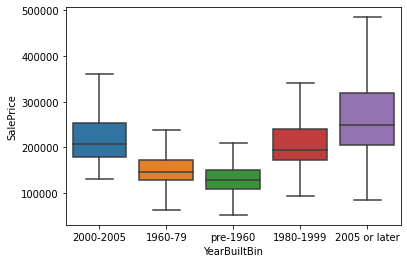

In [137]:
# YearBuiltBin
sns.boxplot(x='YearBuiltBin', y='SalePrice', data=train_df, showfliers=False)

In [138]:
# dropping YearBuilt as I plan to replace it with bins
train_df = train_df.drop(['YearBuilt'], axis = 1)

Checking remaining variables to determine if I will keep, alter, or drop them.

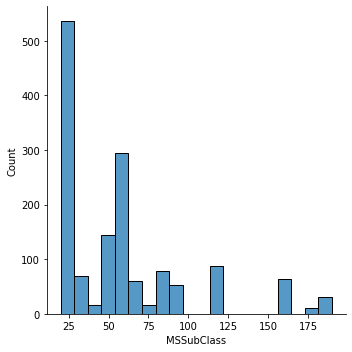

In [25]:
# MSSubClass 
sns.displot(train_df, x = 'MSSubClass')

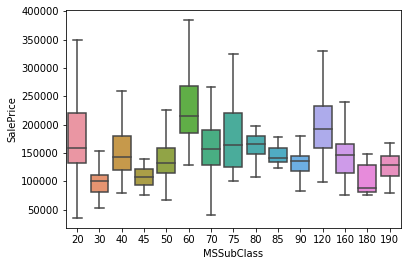

In [26]:
# MSSubClass
sns.boxplot(x='MSSubClass', y='SalePrice', data=train_df, showfliers=False)

In [139]:
# dropping MSSubClass - Not effectively distinguishing between SalePrice ranges, and too many categorical options
train_df = train_df.drop(['MSSubClass'], axis = 1)

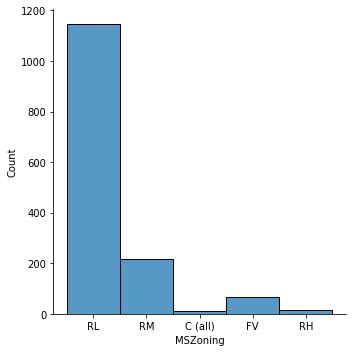

In [28]:
# MSZoning 
sns.displot(train_df, x = 'MSZoning')

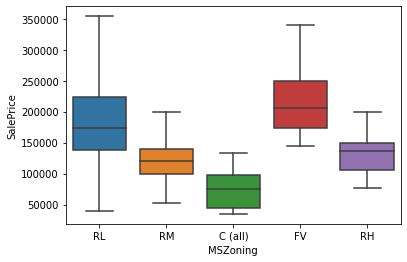

In [29]:
# MSZoning
sns.boxplot(x='MSZoning', y='SalePrice', data=train_df, showfliers=False)

Most homes are category 'RL' (Residential Low Density), and this value encompasses the full range of SalePrice. Still, for other categories, MSZoning appears to differentiate SalePrice distributions. Keeping this variable for now.

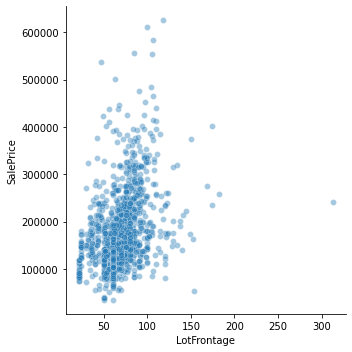

In [31]:
# LotFrontage
# scatter plot showing relationship between LotFrontage and SalePrice
sns.relplot(x='LotFrontage', y='SalePrice', kind='scatter', alpha=0.4, data=train_df).set_title=('SalePrice by LotFrontage')

LotFrontage doesn't have a strong linear relationship with SalePrice. Also, I know I had imputed over 250 of these values to replace nulls. Dropping LotFrontage from the dataset as I don't see it as an effective predictor. 

In [140]:
# dropping LotFrontage
train_df = train_df.drop(['LotFrontage'], axis = 1)

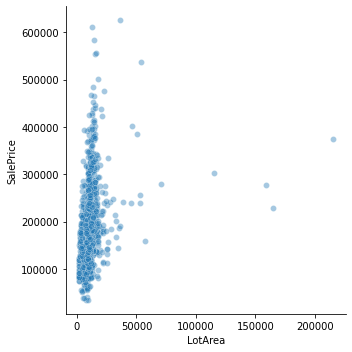

In [33]:
# LotArea
# scatter plot showing relationship between LotArea and SalePrice
sns.relplot(x='LotArea', y='SalePrice', kind='scatter', alpha=0.4, data=train_df).set_title=('SalePrice by LotArea')

LotArea doesn't have a strong linear relationship with SalePrice.  Dropping LotArea from the dataset as I don't see it as an effective predictor. 

In [141]:
# dropping LotArea
train_df = train_df.drop(['LotArea'], axis = 1)

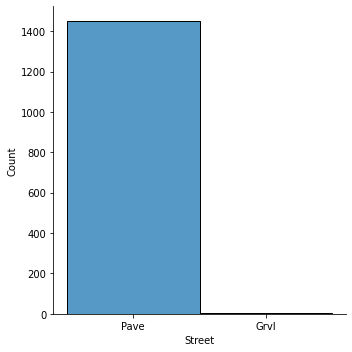

In [35]:
# Street
sns.displot(train_df, x = 'Street')

In [142]:
# dropping Street as almost all observations fall into same category
train_df = train_df.drop(['Street'], axis = 1)

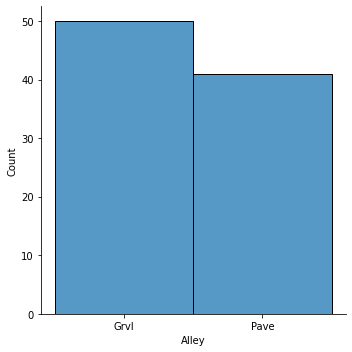

In [37]:
# Alley
sns.displot(train_df, x = 'Alley')

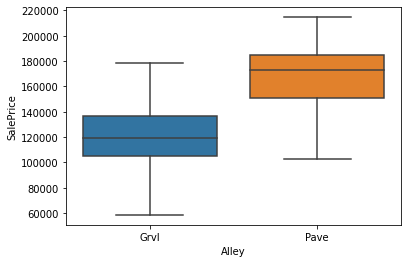

In [38]:
# Alley
sns.boxplot(x='Alley', y='SalePrice', data=train_df, showfliers=False)

Alley appears to have some decent predictive value among homes that do have a datapoint here, but most homes are category 'NA' = 'no alley access'. Dropping this variable. 

In [143]:
# dropping Alley as almost all observations have 'NA'
train_df = train_df.drop(['Alley'], axis = 1)

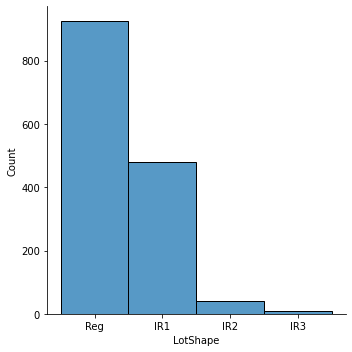

In [40]:
# LotShape
sns.displot(train_df, x = 'LotShape')

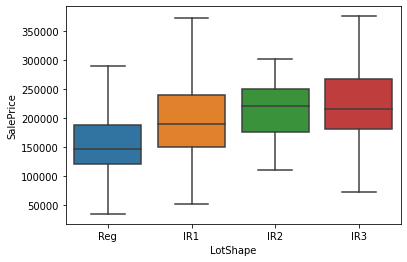

In [41]:
# LotShape
sns.boxplot(x='LotShape', y='SalePrice', data=train_df, showfliers=False)

In [144]:
# dropping LotShape as it does not appear to have differentiating/predictive value
train_df = train_df.drop(['LotShape'], axis = 1)

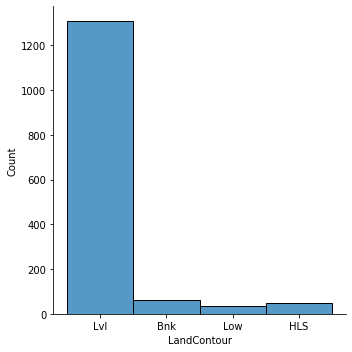

In [43]:
# LandContour
sns.displot(train_df, x = 'LandContour')

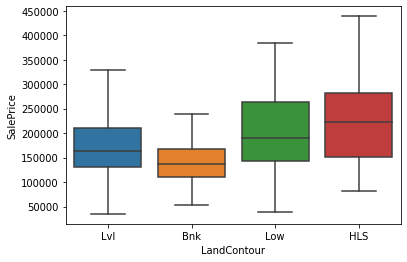

In [44]:
# LandContour
sns.boxplot(x='LandContour', y='SalePrice', data=train_df, showfliers=False)

In [145]:
# dropping LandContour as it does not appear to have differentiating/predictive value
train_df = train_df.drop(['LandContour'], axis = 1)

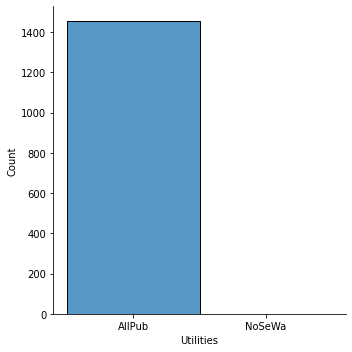

In [46]:
# Utilities
sns.displot(train_df, x = 'Utilities')

In [146]:
# dropping Utilities as almost all observations fall into same category
train_df = train_df.drop(['Utilities'], axis = 1)

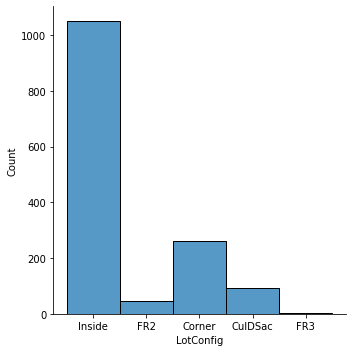

In [48]:
# LotConfig
sns.displot(train_df, x = 'LotConfig')

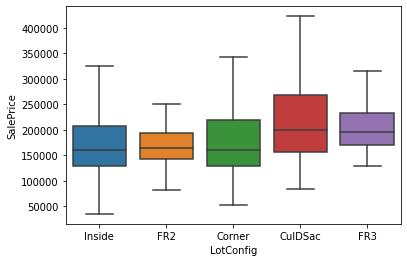

In [49]:
# LotConfig
sns.boxplot(x='LotConfig', y='SalePrice', data=train_df, showfliers=False)

In [147]:
# dropping LotConfig as it does not appear to have differentiating/predictive value
train_df = train_df.drop(['LotConfig'], axis = 1)

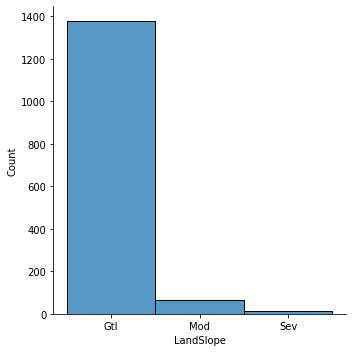

In [51]:
# LandSlope
sns.displot(train_df, x = 'LandSlope')

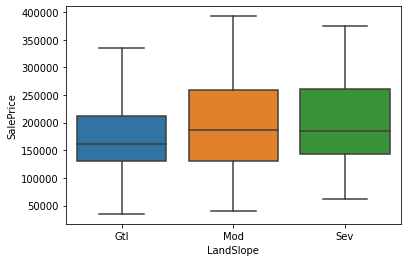

In [52]:
# LandSlope
sns.boxplot(x='LandSlope', y='SalePrice', data=train_df, showfliers=False)

In [148]:
# dropping LandSlope as almost all homes are within one category, and it does not appear to have differentiating/predictive value
train_df = train_df.drop(['LandSlope'], axis = 1)

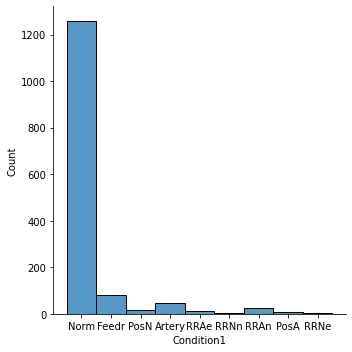

In [54]:
# Condition1
sns.displot(train_df, x = 'Condition1')

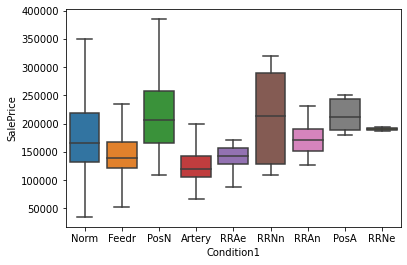

In [55]:
# Condition1
sns.boxplot(x='Condition1', y='SalePrice', data=train_df, showfliers=False)

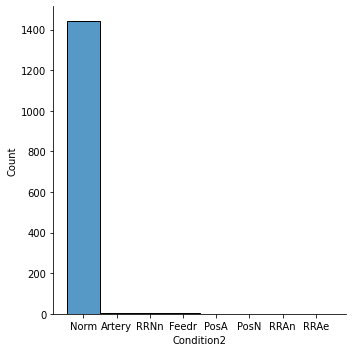

In [57]:
# Condition2
sns.displot(train_df, x = 'Condition2')

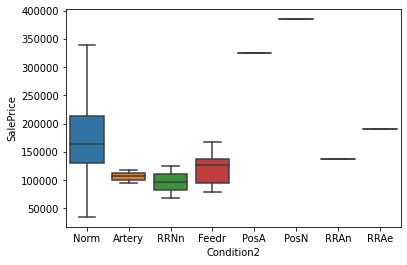

In [56]:
# Condition2
sns.boxplot(x='Condition2', y='SalePrice', data=train_df, showfliers=False)

Conditions 1 and 2 have a lot of categories that don't apply to most homes, but there appears to be some differentiation among the homes that do have a 'condition' that applies. I am choosing to create a new categorical variable, 'RRAdjacent', which will equal 1 if the home is adjacent to a railroad (regardless of E-W/N-S direction) in either Condition 1 or Condition 2 and 0 if it is not. Then, I will drop the Condition 1 and 2 variables.

In [63]:
# new variable: RRAdjacent
train_df['RRAdjacent'] = np.where((train_df['Condition1'].str.contains('RR')) | (train_df['Condition2'].str.contains('RR')), '1', '0')

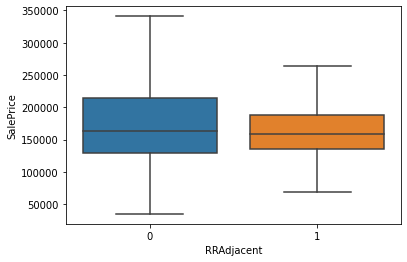

In [82]:
# RRAdjacent
sns.boxplot(x='RRAdjacent', y='SalePrice', data=train_df, showfliers=False)

RRAdjacent was worth looking into, but still doesn't appear to have differentiating value as I had hoped. Dropping RRAdjacent.

In [83]:
# drop RRAdjacent
train_df = train_df.drop(['RRAdjacent'], axis = 1)

In [149]:
# drop Conditions 1 and 2
train_df = train_df.drop(['Condition1'], axis = 1)
train_df = train_df.drop(['Condition2'], axis = 1)

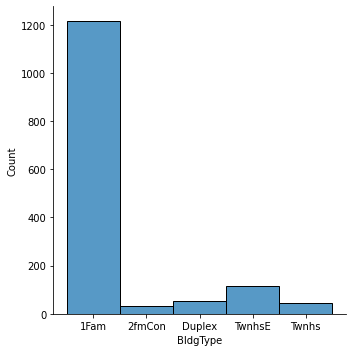

In [65]:
# BldgType
sns.displot(train_df, x = 'BldgType')

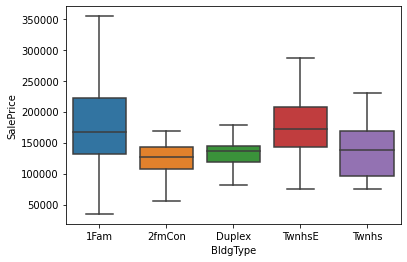

In [66]:
# BldgType
sns.boxplot(x='BldgType', y='SalePrice', data=train_df, showfliers=False)

I do see some differentiating value among the categories for BldgType, but specifically in the tighter ranges of SalePrice for both 2fmCon and Duplex building types. I'm going to create a new categorical variable - NumFam - and group townhouses (both inside and end units) with single family homes, and group both 2fmCon and Duplex homes together. Then, I'm going to drop BldgType.

In [150]:
# new variable: NumFam
train_df['NumFam'] = np.where((train_df['BldgType'] == '2fmCon') | (train_df['BldgType'] == 'Duplex'), 'Multi', 'Single')

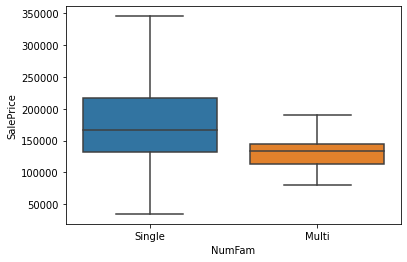

In [25]:
# NumFam
sns.boxplot(x='NumFam', y='SalePrice', data=train_df, showfliers=False)

In [151]:
# drop BldgType
train_df = train_df.drop(['BldgType'], axis = 1)

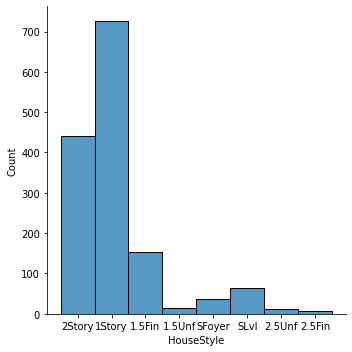

In [71]:
# HouseStyle
sns.displot(train_df, x = 'HouseStyle')

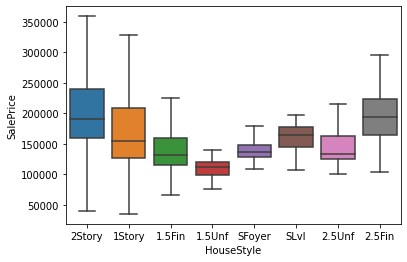

In [72]:
# HouseStyle
sns.boxplot(x='HouseStyle', y='SalePrice', data=train_df, showfliers=False)

Dropping HouseStyle - though categories appear to have differentiating value, most homes fall into 2 categories which have high overlap in SalePrice.

In [152]:
# drop HouseStyle
train_df = train_df.drop(['HouseStyle'], axis = 1)

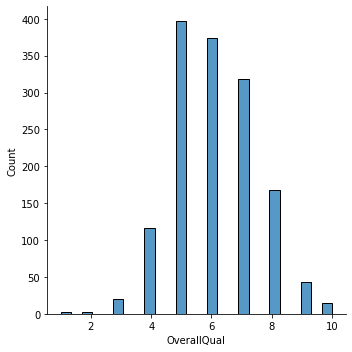

In [74]:
# OverallQual
sns.displot(train_df, x = 'OverallQual')

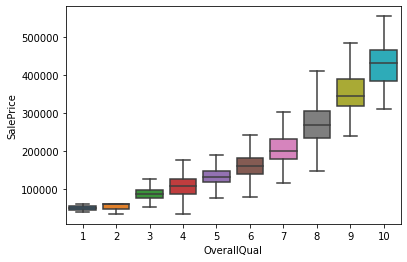

In [75]:
# OverallQual
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df, showfliers=False)

OverallQual is very nicely diffentiating of SalePrice ranges. I am going to keep this variable as-is.

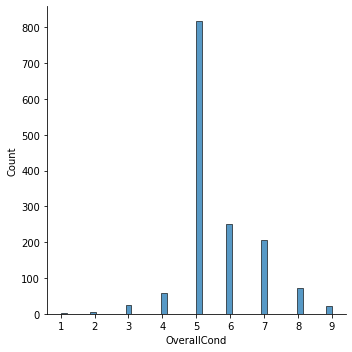

In [76]:
# OverallCond
sns.displot(train_df, x = 'OverallCond')

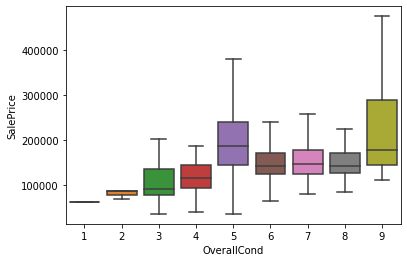

In [77]:
# OverallCond
sns.boxplot(x='OverallCond', y='SalePrice', data=train_df, showfliers=False)

Unlike OverallQual, OverallCond doesn't appear to differentiate SalePrice ranges as-is. I am going to create a new variable, 'RelativeCond', with values 'Above Average' for homes with OverallCond greater than or equal to 5, otherwise 'Below Average'. Then, I'm going to drop OverallCond.

In [153]:
# new variable: RelativeCond
train_df['RelativeCond'] = np.where(train_df['OverallCond'] >= 5, 'Above Average', 'Below Average')

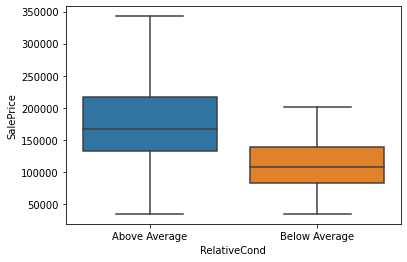

In [29]:
# RelativeCond
sns.boxplot(x='RelativeCond', y='SalePrice', data=train_df, showfliers=False)

# Nice!

In [154]:
# drop OverallCond
train_df = train_df.drop(['OverallCond'], axis = 1)

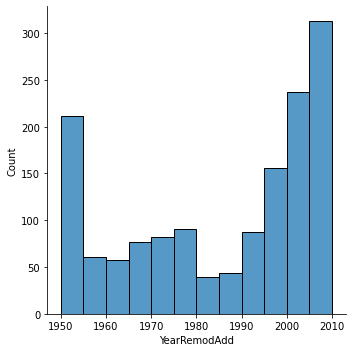

In [84]:
# YearRemodAdd
sns.displot(train_df, x = 'YearRemodAdd')

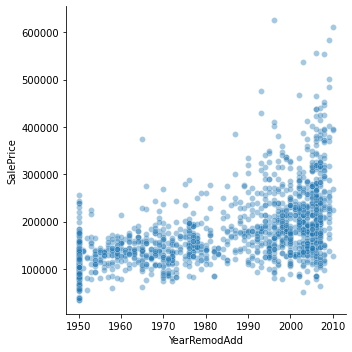

In [155]:
# YearRemodAdd
sns.relplot(x='YearRemodAdd', y='SalePrice', kind='scatter', alpha=0.4, data=train_df)

YearRemodAdd appears to have a pretty bimodal distribution - creating a new categorical variable 'LastRemod', then dropping YearRemodAdd.

In [161]:
# new variable: LastRemod
train_df['LastRemod'] = np.where(train_df['YearRemodAdd'] >= 1980, 'Since1980', 'Pre1980')

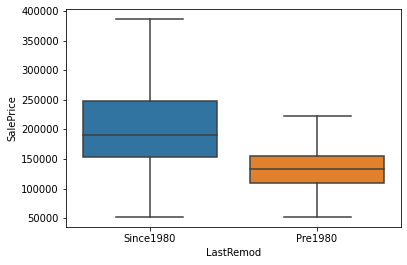

In [162]:
# LastRemod
sns.boxplot(x='LastRemod', y='SalePrice', data=train_df, showfliers=False)

# Nice!

In [217]:
# drop YearRemodAdd
train_df = train_df.drop(['YearRemodAdd'], axis = 1)

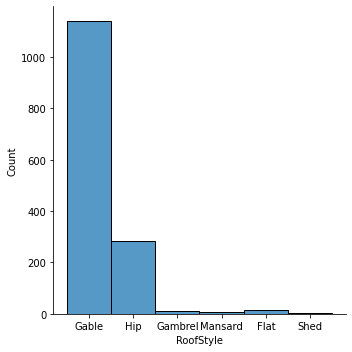

In [92]:
# RoofStyle
sns.displot(train_df, x = 'RoofStyle')

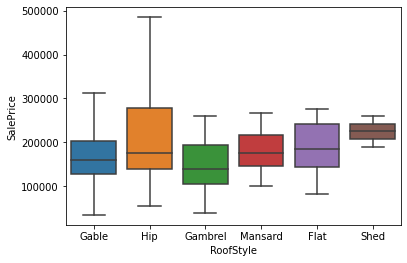

In [93]:
# RoofStyle
sns.boxplot(x='RoofStyle', y='SalePrice', data=train_df, showfliers=False)

In [163]:
# drop RoofStyle - does not appear to differentiate SalePrice
train_df = train_df.drop(['RoofStyle'], axis = 1)

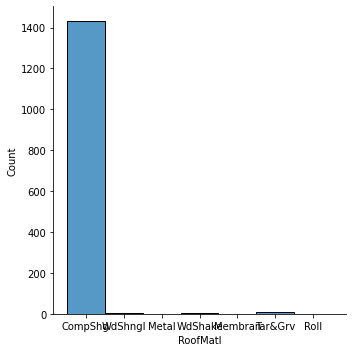

In [95]:
# RoofMatl
sns.displot(train_df, x = 'RoofMatl')

In [164]:
# drop RoofMatl - almost all homes within one category
train_df = train_df.drop(['RoofMatl'], axis = 1)

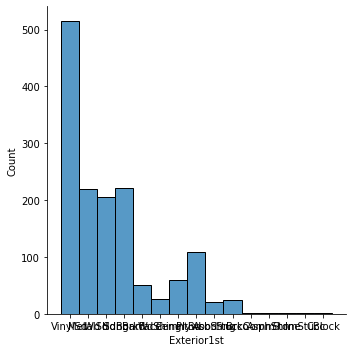

In [97]:
# Exterior1st
sns.displot(train_df, x = 'Exterior1st')

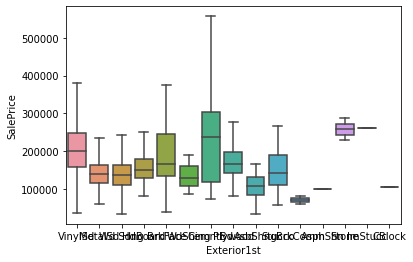

In [98]:
# Exterior1st
sns.boxplot(x='Exterior1st', y='SalePrice', data=train_df, showfliers=False)

In [165]:
# drop Exterior1st - while there is some differentiation, too many categories
train_df = train_df.drop(['Exterior1st'], axis = 1)

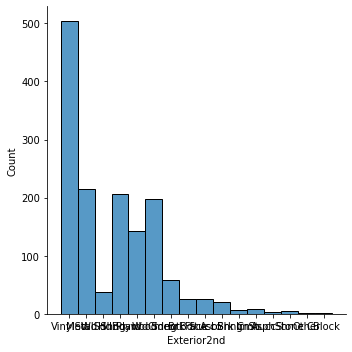

In [100]:
# Exterior2nd
sns.displot(train_df, x = 'Exterior2nd')

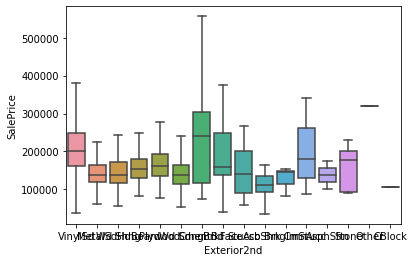

In [101]:
# Exterior2nd
sns.boxplot(x='Exterior2nd', y='SalePrice', data=train_df, showfliers=False)

In [166]:
# drop Exterior2nd - while there is some differentiation, too many categories
train_df = train_df.drop(['Exterior2nd'], axis = 1)

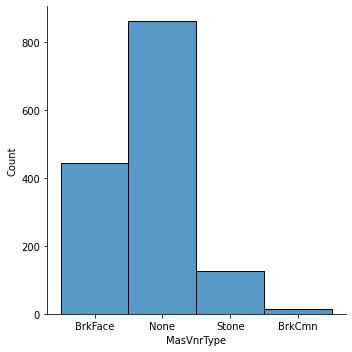

In [105]:
# MasVnrType
sns.displot(train_df, x = 'MasVnrType')

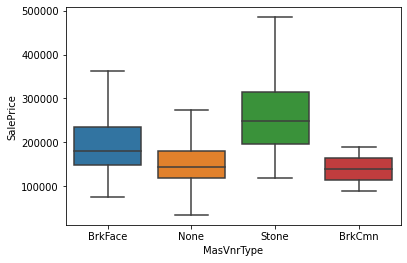

In [106]:
# MasVnrType
sns.boxplot(x='MasVnrType', y='SalePrice', data=train_df, showfliers=False)

Keeping MasVnrType as it does appear to differentiate SalePrice.

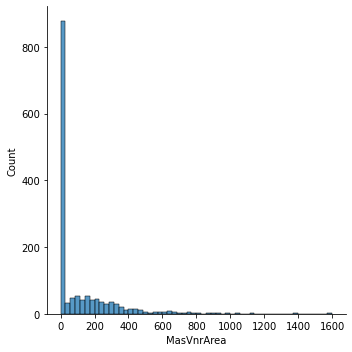

In [107]:
# MasVnrArea
sns.displot(train_df, x = 'MasVnrArea')

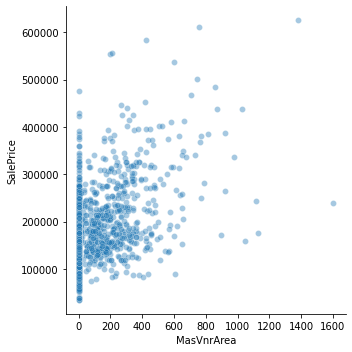

In [108]:
# MasVnrArea
# scatter plot showing relationship between MasVnrArea and SalePrice
sns.relplot(x='MasVnrArea', y='SalePrice', kind='scatter', alpha=0.4, data=train_df).set_title=('SalePrice by MasVnrArea')

MasVnrArea doesn't appear to have a linear relationship with SalePrice, and most values are 0. Dropping this variable.

In [167]:
# drop MasVnrArea
train_df = train_df.drop(['MasVnrArea'], axis = 1)

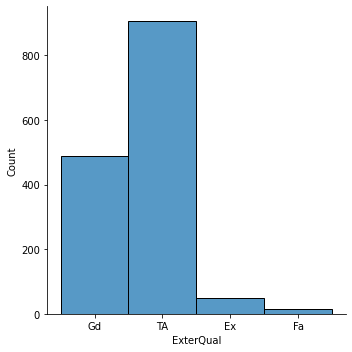

In [103]:
# ExterQual
sns.displot(train_df, x = 'ExterQual')

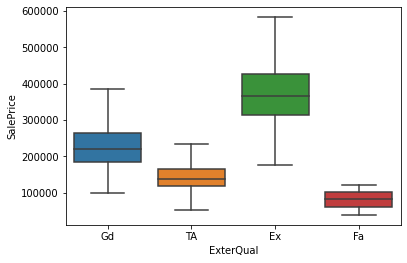

In [104]:
# ExterQual
sns.boxplot(x='ExterQual', y='SalePrice', data=train_df, showfliers=False)

SalePrice does appear to be differentiated by ExterQual, moreso than the previous home exterior categorical variables. Keeping this as-is.

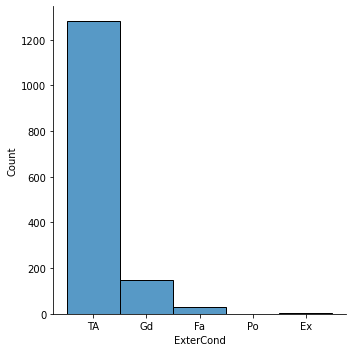

In [109]:
# ExterCond
sns.displot(train_df, x = 'ExterCond')

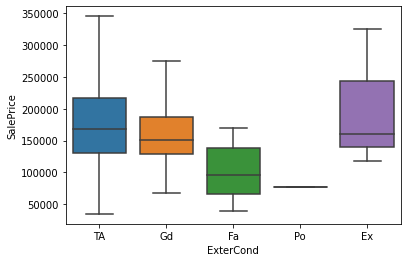

In [110]:
# ExterCond
sns.boxplot(x='ExterCond', y='SalePrice', data=train_df, showfliers=False)

In [168]:
# dropping ExterCond - most homes in one category and not great differentiation of SalePrice
train_df = train_df.drop(['ExterCond'], axis = 1)

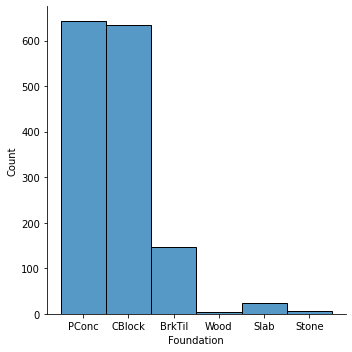

In [110]:
# Foundation
sns.displot(train_df, x = 'Foundation')

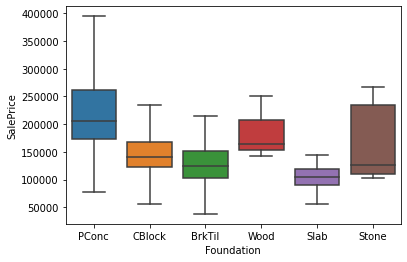

In [111]:
# Foundation
sns.boxplot(x='Foundation', y='SalePrice', data=train_df, showfliers=False)

Foundation does appear to differentiate; keeping this variable as-is.


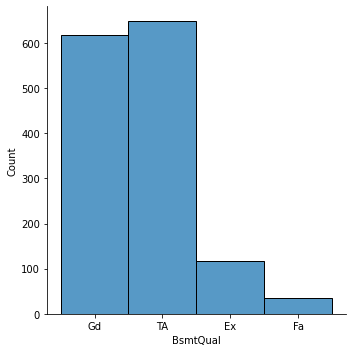

In [112]:
# BsmtQual
sns.displot(train_df, x = 'BsmtQual')

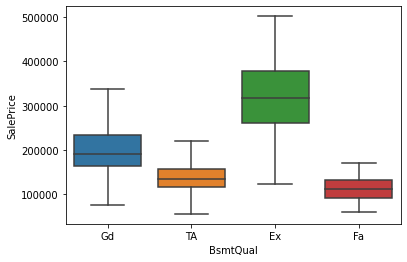

In [113]:
# BsmtQual
sns.boxplot(x='BsmtQual', y='SalePrice', data=train_df, showfliers=False)

BsmtQual does appear to differentiate; keeping this variable as-is.

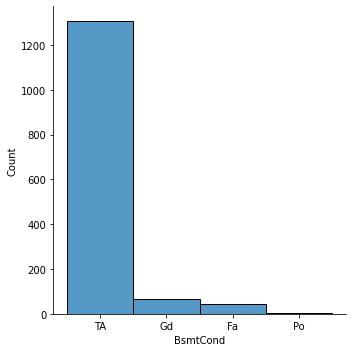

In [114]:
# BsmtCond
sns.displot(train_df, x = 'BsmtCond')

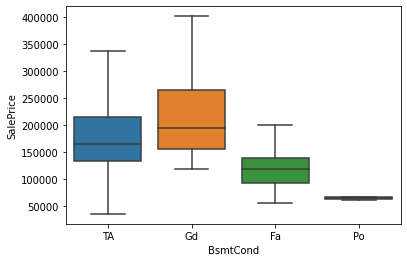

In [115]:
# BsmtCond
sns.boxplot(x='BsmtCond', y='SalePrice', data=train_df, showfliers=False)

Most homes fall into one category for BsmtCond; dropping this variable.

In [169]:
# drop BsmtCond
train_df = train_df.drop(['BsmtCond'], axis = 1)

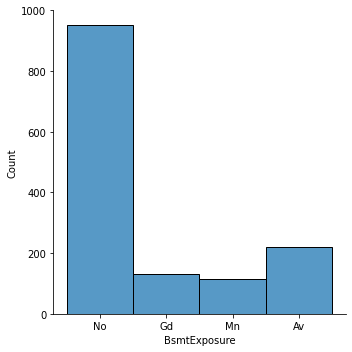

In [117]:
# BsmtExposure
sns.displot(train_df, x = 'BsmtExposure')

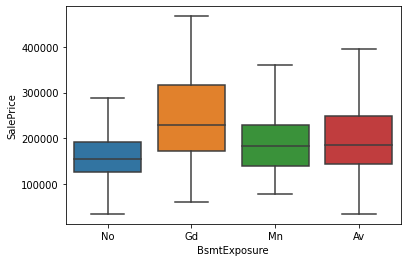

In [118]:
# BsmtExposure
sns.boxplot(x='BsmtExposure', y='SalePrice', data=train_df, showfliers=False)

BsmtExposure is not a great differentiator; dropping this variable.

In [170]:
# drop BsmtExposure
train_df = train_df.drop(['BsmtExposure'], axis = 1)

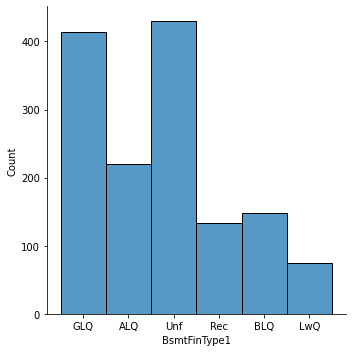

In [120]:
# BsmtFinType1
sns.displot(train_df, x = 'BsmtFinType1')

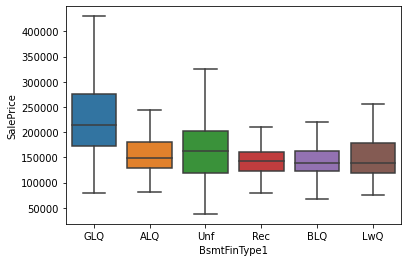

In [121]:
# BsmtFinType1
sns.boxplot(x='BsmtFinType1', y='SalePrice', data=train_df, showfliers=False)

BsmtFinType1 is not a great differentiator; dropping this variable.

In [171]:
# drop BsmtFinType1
train_df = train_df.drop(['BsmtFinType1'], axis = 1)

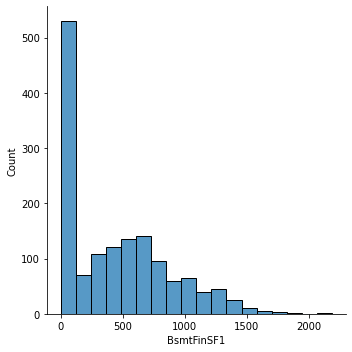

In [125]:
# BsmtFinSF1
sns.displot(train_df, x = 'BsmtFinSF1')

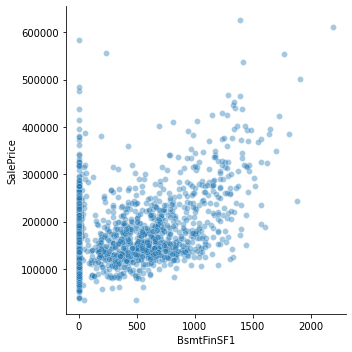

In [126]:
# scatter plot showing relationship between BsmtFinSF1 and SalePrice
sns.relplot(x='BsmtFinSF1', y='SalePrice', kind='scatter', alpha=0.4, data=train_df)

There does appear to be some linear relationship between BsmtFinSF1 and SalePrice, but not as apparently strong as other numeric variables. Dropping this variable. 

In [172]:
# drop BsmtFinSF1
train_df = train_df.drop(['BsmtFinSF1'], axis = 1)

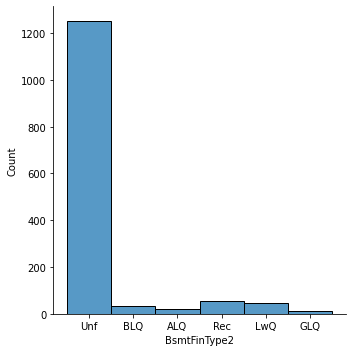

In [123]:
# BsmtFinType2
sns.displot(train_df, x = 'BsmtFinType2')

In [173]:
# drop BsmtFinType2 - most homes fall into one category
train_df = train_df.drop(['BsmtFinType2'], axis = 1)

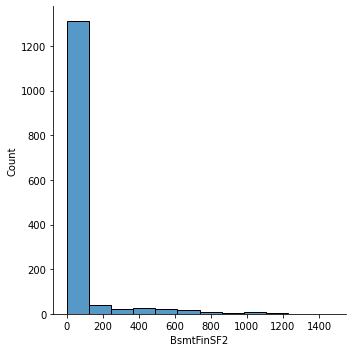

In [128]:
# BsmtFinSF2
sns.displot(train_df, x = 'BsmtFinSF2')

In [174]:
# drop BsmtFinSF2 - most homes have value 0
train_df = train_df.drop(['BsmtFinSF2'], axis = 1)

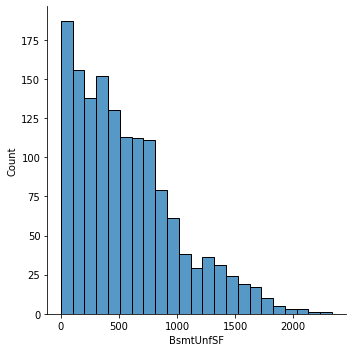

In [130]:
# BsmtUnfSF
sns.displot(train_df, x = 'BsmtUnfSF')

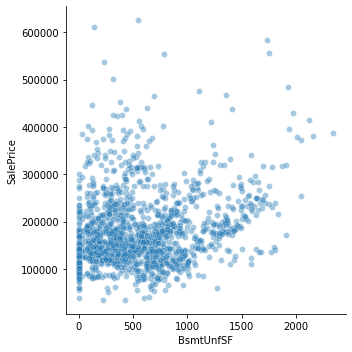

In [131]:
# scatter plot showing relationship between BsmtUnfSF and SalePrice
sns.relplot(x='BsmtUnfSF', y='SalePrice', kind='scatter', alpha=0.4, data=train_df)

Relationship does not appear very linear; dropping this variable. 

In [175]:
# drop BsmtUnfSF
train_df = train_df.drop(['BsmtUnfSF'], axis = 1)

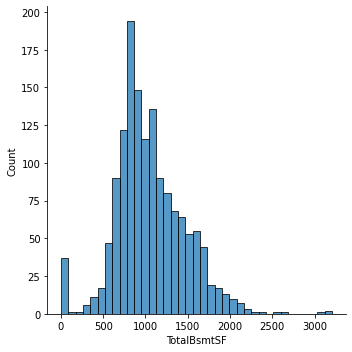

In [133]:
# TotalBsmtSF
sns.displot(train_df, x = 'TotalBsmtSF')

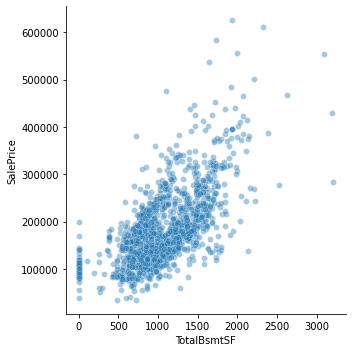

In [134]:
# scatter plot showing relationship between TotalBsmtSF and SalePrice
sns.relplot(x='TotalBsmtSF', y='SalePrice', kind='scatter', alpha=0.4, data=train_df)

Fairly strong positive linear relationship between TotalBsmtSF and SalePrice; keeping this variable.

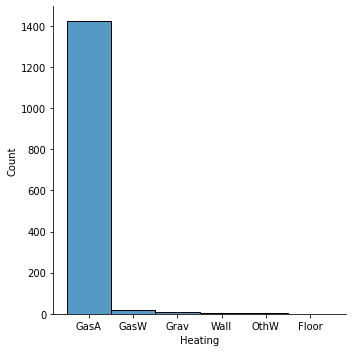

In [135]:
# Heating
sns.displot(train_df, x = 'Heating')

In [176]:
# drop Heating - almost all homes in same category
train_df = train_df.drop(['Heating'], axis = 1)

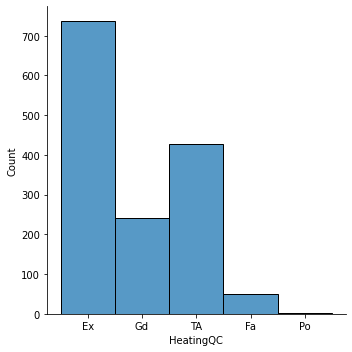

In [137]:
# HeatingQC
sns.displot(train_df, x = 'HeatingQC')

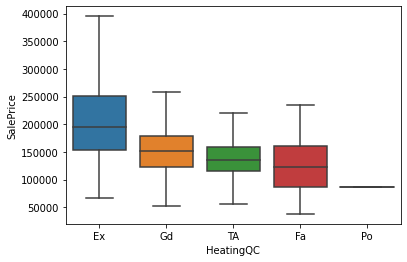

In [138]:
# HeatingQC
sns.boxplot(x='HeatingQC', y='SalePrice', data=train_df, showfliers=False)

Keeping HeatingQC as there is some diffentiation of SalePrice distribution among categories.

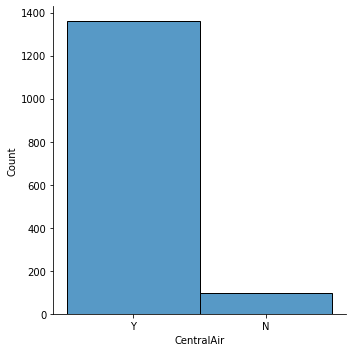

In [139]:
# CentralAir
sns.displot(train_df, x = 'CentralAir')

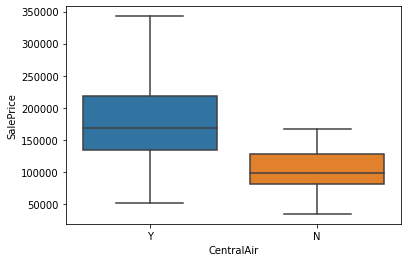

In [140]:
# CentralAir
sns.boxplot(x='CentralAir', y='SalePrice', data=train_df, showfliers=False)

While most homes have Central Air, there is a clear distinction in SalePrice distribution for homes that do not. Keeping this variable. 

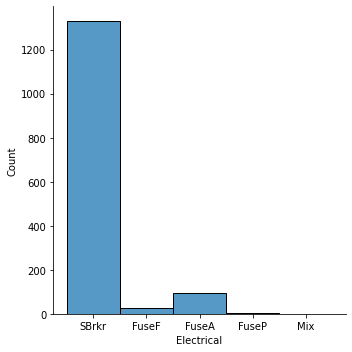

In [141]:
# Electrical
sns.displot(train_df, x = 'Electrical')

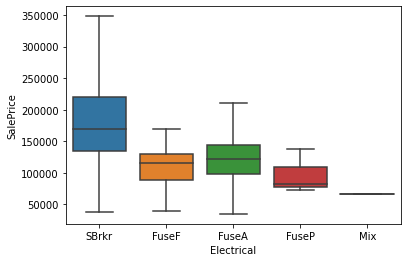

In [142]:
# Electrical
sns.boxplot(x='Electrical', y='SalePrice', data=train_df, showfliers=False)

Dropping Electrical - most homes in one category, and not great differentiation of SalePrice among remaining categories.

In [177]:
# drop Electrical
train_df = train_df.drop(['Electrical'], axis = 1)

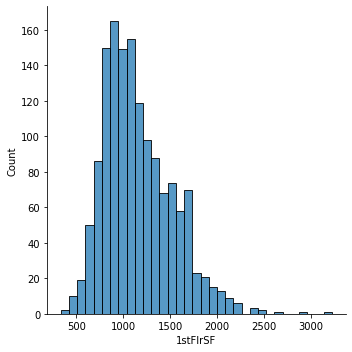

In [178]:
# 1stFlrSF
sns.displot(train_df, x = '1stFlrSF')

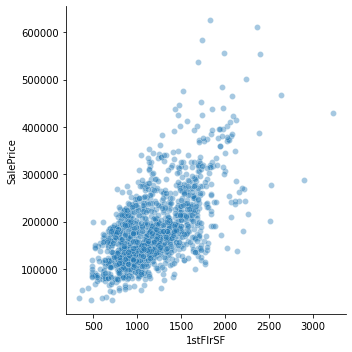

In [145]:
# scatter plot showing relationship between 1stFlrSF and SalePrice
sns.relplot(x='1stFlrSF', y='SalePrice', kind='scatter', alpha=0.4, data=train_df)

Decent linear relationship - keeping this variable for now, but may drop later if highly correlated with other SF variables (which I expect).

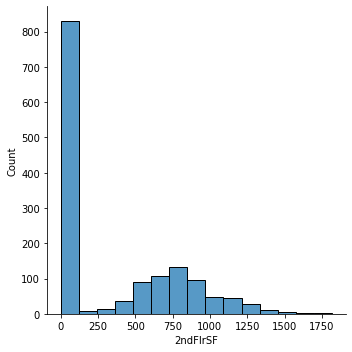

In [179]:
# 2ndFlrSF
sns.displot(train_df, x = '2ndFlrSF')

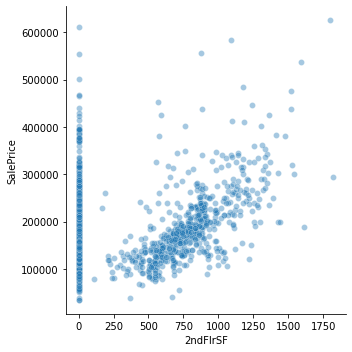

In [147]:
# scatter plot showing relationship between 2ndFlrSF and SalePrice
sns.relplot(x='2ndFlrSF', y='SalePrice', kind='scatter', alpha=0.4, data=train_df)

Limited linear relationship as many homes have value of 0. Dropping this variable - expecting to have better predictive power with total square footage.

In [180]:
# drop 2ndFlrSF
train_df = train_df.drop(['2ndFlrSF'], axis = 1)

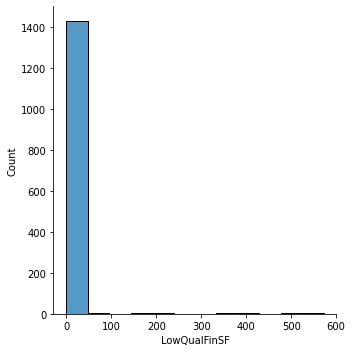

In [149]:
# LowQualFinSF
sns.displot(train_df, x = 'LowQualFinSF')

In [181]:
# drop LowQualFinSF - most homes at 0
train_df = train_df.drop(['LowQualFinSF'], axis = 1)

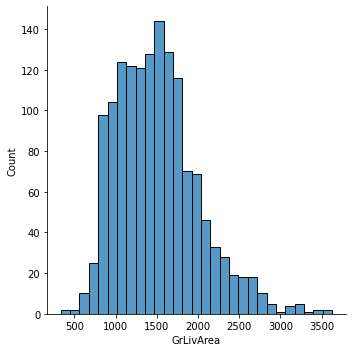

In [151]:
# GrLivArea
sns.displot(train_df, x = 'GrLivArea')

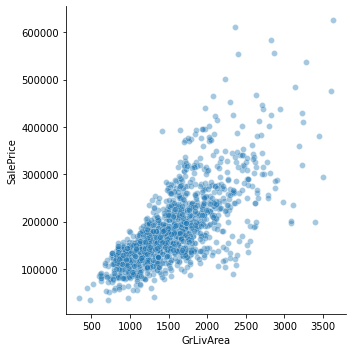

In [182]:
# scatter plot showing relationship between GrLivArea and SalePrice
sns.relplot(x='GrLivArea', y='SalePrice', kind='scatter', alpha=0.4, data=train_df)

Clear linear relationship; keeping this variable.

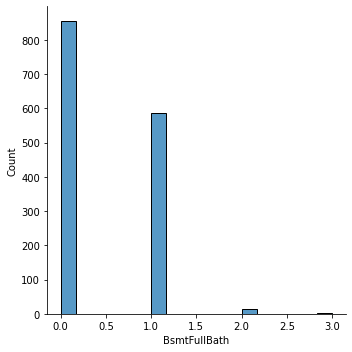

In [153]:
# BsmtFullBath
sns.displot(train_df, x = 'BsmtFullBath')

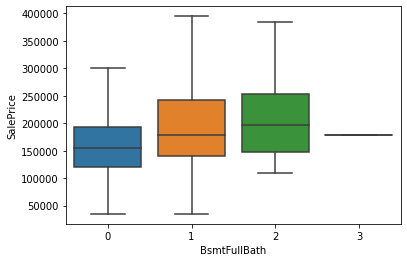

In [154]:
# BsmtFullBath
sns.boxplot(x='BsmtFullBath', y='SalePrice', data=train_df, showfliers=False)

BsmtFullBath is not actually a great differentiator; will keep variable for now - planning to do further transformation on bathroom count - but planning to exclude this from model. 

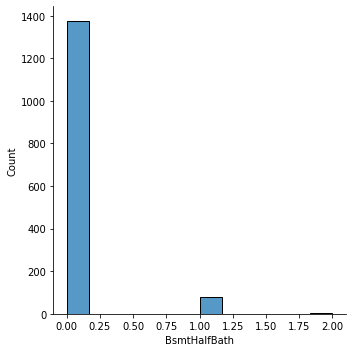

In [155]:
# BsmtHalfBath
sns.displot(train_df, x = 'BsmtHalfBath')

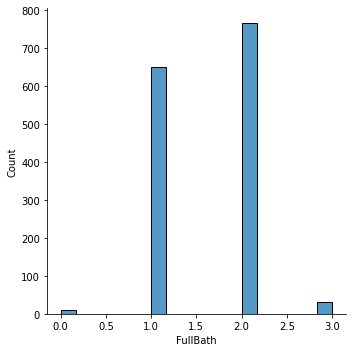

In [156]:
# FullBath
sns.displot(train_df, x = 'FullBath')

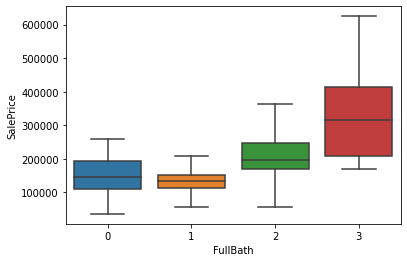

In [157]:
# FullBath
sns.boxplot(x='FullBath', y='SalePrice', data=train_df, showfliers=False)

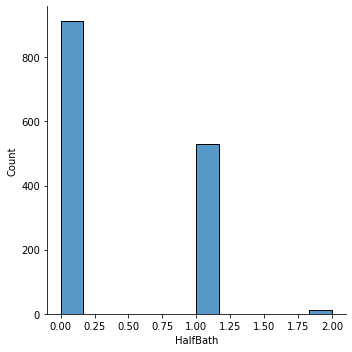

In [158]:
# HalfBath
sns.displot(train_df, x = 'HalfBath')

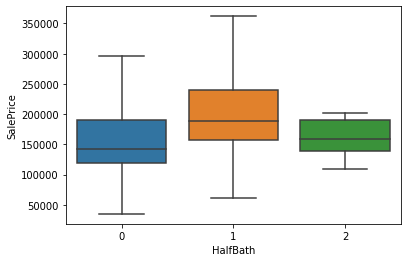

In [159]:
# HalfBath
sns.boxplot(x='HalfBath', y='SalePrice', data=train_df, showfliers=False)

In [183]:
# new variable - total full baths
train_df['TotalFullBath'] = train_df['FullBath'] + train_df['BsmtFullBath'] 

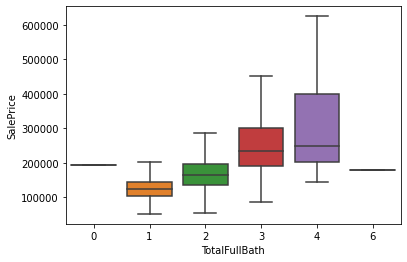

In [162]:
# TotalFullBath
sns.boxplot(x='TotalFullBath', y='SalePrice', data=train_df, showfliers=False)

In [184]:
# new variable - total half baths
train_df['TotalHalfBath'] = train_df['HalfBath'] + train_df['BsmtHalfBath'] 

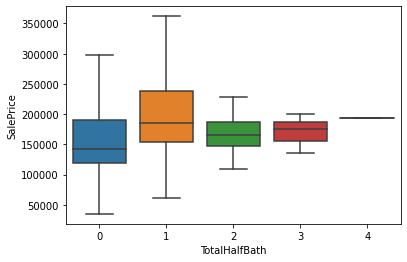

In [164]:
# TotalHalfBath
sns.boxplot(x='TotalHalfBath', y='SalePrice', data=train_df, showfliers=False)

Total full baths does appear to have differentiating value, but total half baths does not (and two half baths does not equal a full bath). Dropping all but TotalFullBaths from the bathroom categorical variables. 

In [185]:
# drop Bathroom categorical vars not using
train_df = train_df.drop(['BsmtFullBath'], axis = 1)
train_df = train_df.drop(['BsmtHalfBath'], axis = 1)
train_df = train_df.drop(['FullBath'], axis = 1)
train_df = train_df.drop(['HalfBath'], axis = 1)
train_df = train_df.drop(['TotalHalfBath'], axis = 1)

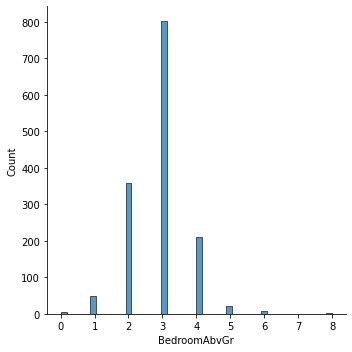

In [166]:
# BedroomAbvGr
sns.displot(train_df, x = 'BedroomAbvGr')

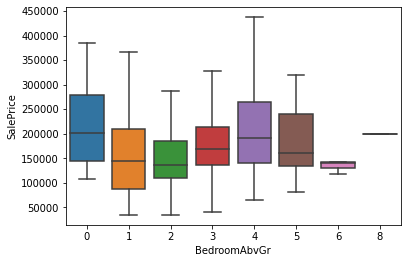

In [167]:
# BedroomAbvGr
sns.boxplot(x='BedroomAbvGr', y='SalePrice', data=train_df, showfliers=False)

Bedroom count is (somewhat surprisingly) not a great differentiator of home SalePrice. Dropping this variable.

In [186]:
# drop BedroomAbvGr 
train_df = train_df.drop(['BedroomAbvGr'], axis = 1)

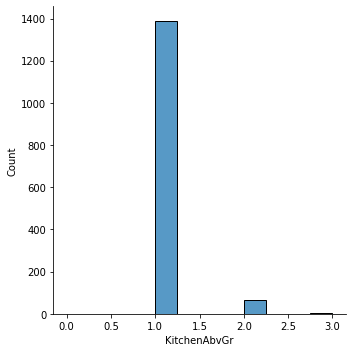

In [169]:
# KitchenAbvGr
sns.displot(train_df, x = 'KitchenAbvGr')

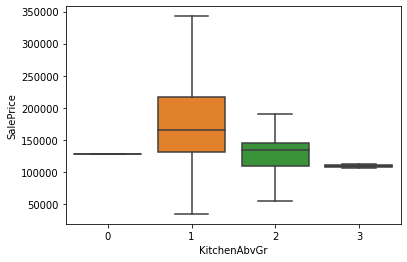

In [187]:
# KitchenAbvGr
sns.boxplot(x='KitchenAbvGr', y='SalePrice', data=train_df, showfliers=False)

Nearly all homes have just one kitchen, but those that fall in other categories are not well differentiated in SalePrice. Dropping this variable. 

In [188]:
# drop KitchenAbvGr 
train_df = train_df.drop(['KitchenAbvGr'], axis = 1)

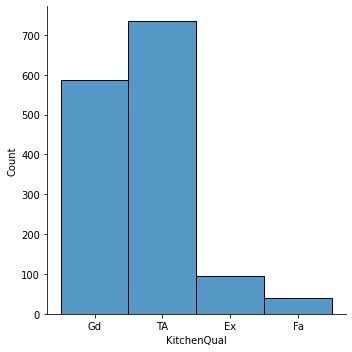

In [172]:
# KitchenQual
sns.displot(train_df, x = 'KitchenQual')

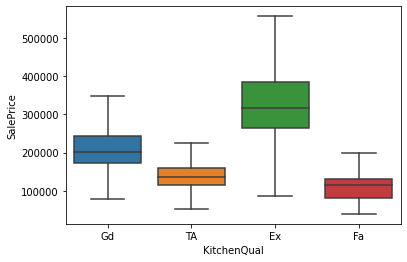

In [173]:
# KitchenQual
sns.boxplot(x='KitchenQual', y='SalePrice', data=train_df, showfliers=False)

KitchenQual is a solid differentiator of SalePrice. Keeping this variable.

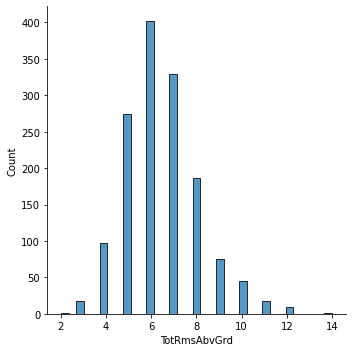

In [175]:
# TotRmsAbvGrd
sns.displot(train_df, x = 'TotRmsAbvGrd')

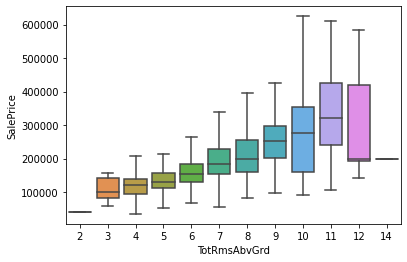

In [177]:
# TotRmsAbvGrd
sns.boxplot(x='TotRmsAbvGrd', y='SalePrice', data=train_df, showfliers=False)

TotRmsAbvGrd does have some differentiation of SalePrice, but I think there's an opportunity to reduce the number of categories and bin here. Creating new variable 'TotRmsBin'. Then dropping TotRmsAbvGrd.

In [189]:
# TotRmsAbvGr could be a categorical variable with binned ranges

# function to bin 
def get_rooms_bin(TotRmsAbvGrd):
  if TotRmsAbvGrd <= 5:
    return '5 or fewer'

  elif TotRmsAbvGrd <= 8:
    return '6-8'
  
  else:
    return '9 or more'


train_df['TotRmsBin'] = train_df['TotRmsAbvGrd'].apply(get_rooms_bin)

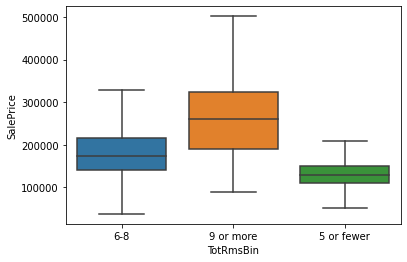

In [190]:
# TotRmsBin
sns.boxplot(x='TotRmsBin', y='SalePrice', data=train_df, showfliers=False)

In [191]:
# drop TotRmsAbvGrd
train_df = train_df.drop(['TotRmsAbvGrd'], axis = 1)

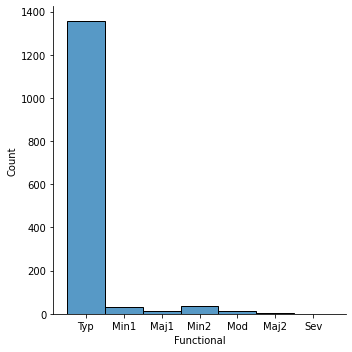

In [180]:
# Functional
sns.displot(train_df, x = 'Functional')

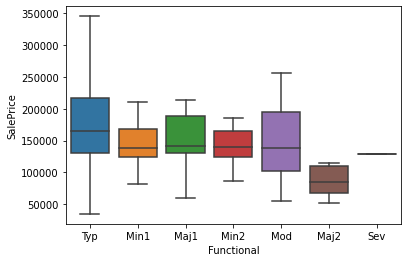

In [181]:
# Functional
sns.boxplot(x='Functional', y='SalePrice', data=train_df, showfliers=False)

Nearly all homes are graded typical functionality, and those that are not do not have a solid differentiation in SalePrice. Dropping this variable. 

In [192]:
# drop Functional
train_df = train_df.drop(['Functional'], axis = 1)

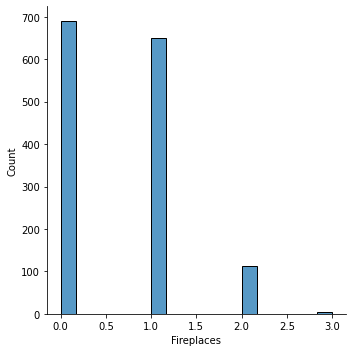

In [183]:
# Fireplaces
sns.displot(train_df, x = 'Fireplaces')

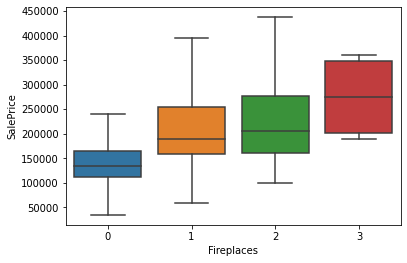

In [184]:
# Fireplaces
sns.boxplot(x='Fireplaces', y='SalePrice', data=train_df, showfliers=False)

The presence/absence of a fireplace does appear to differentiate, but not the number of fireplaces. Dropping this variable, planning to keep the 'HasFireplace' categorical variable I created previously.

In [193]:
# drop Fireplaces
train_df = train_df.drop(['Fireplaces'], axis = 1)

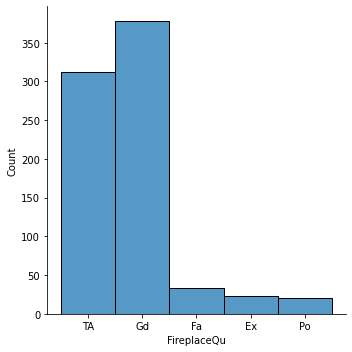

In [186]:
# FireplaceQu
sns.displot(train_df, x = 'FireplaceQu')

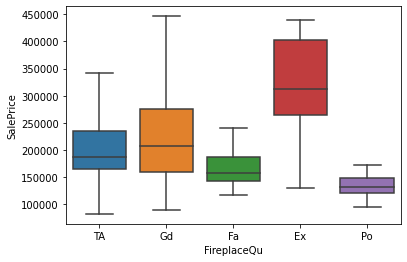

In [187]:
# FireplaceQu
sns.boxplot(x='FireplaceQu', y='SalePrice', data=train_df, showfliers=False)

Among those homes with fireplaces, fireplace quality does appear to be a decent differentiator. Keeping this variable. 

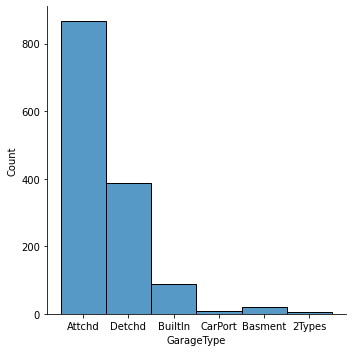

In [188]:
# GarageType
sns.displot(train_df, x = 'GarageType')

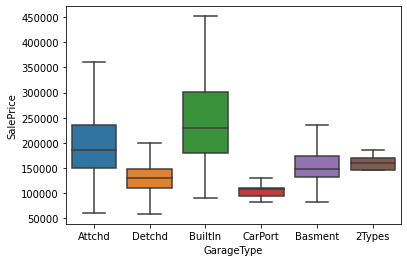

In [189]:
# GarageType
sns.boxplot(x='GarageType', y='SalePrice', data=train_df, showfliers=False)

Among homes that do have a garage, garage type does appear to differentiate SalePrice. Keeping this variable. 

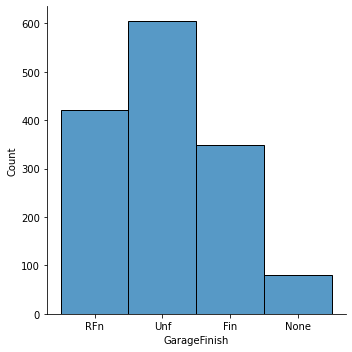

In [219]:
# GarageFinish
sns.displot(train_df, x = 'GarageFinish')

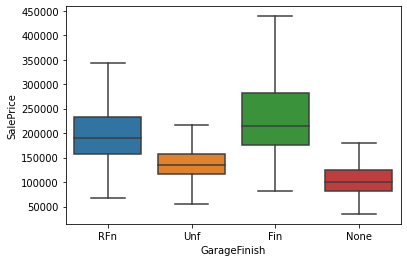

In [220]:
# GarageFinish
sns.boxplot(x='GarageFinish', y='SalePrice', data=train_df, showfliers=False)

GarageFinish appears to be a decent differentiator; keeping this variable.

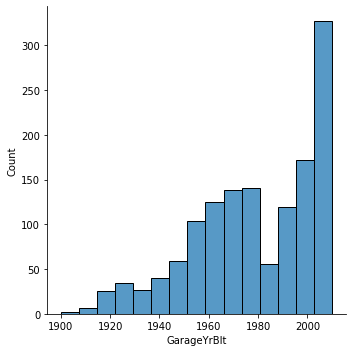

In [190]:
# GarageYrBlt
sns.displot(train_df, x = 'GarageYrBlt')

GarageYrBlt appears to closely resemble the distribution of YearBuilt; dropping this variable.

In [194]:
# drop GarageYrBlt
train_df = train_df.drop(['GarageYrBlt'], axis = 1)

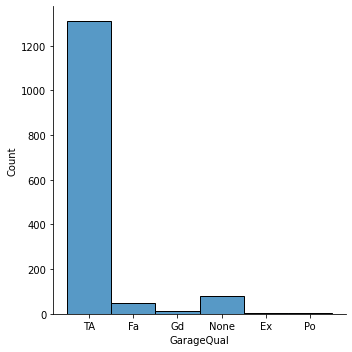

In [203]:
# GarageQual
sns.displot(train_df, x = 'GarageQual')

In [195]:
# most homes fall into one category; dropping GarageQual
train_df = train_df.drop(['GarageQual'], axis = 1)

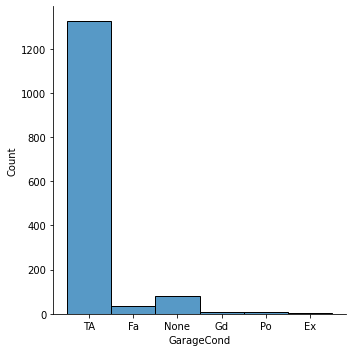

In [205]:
# GarageCond
sns.displot(train_df, x = 'GarageCond')

In [196]:
# most homes fall into one category; dropping GarageCond
train_df = train_df.drop(['GarageCond'], axis = 1)

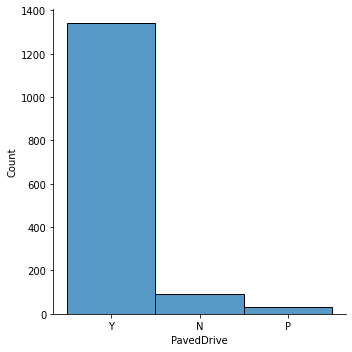

In [207]:
# PavedDrive
sns.displot(train_df, x = 'PavedDrive')

In [197]:
# most homes fall into one category; dropping PavedDrive
train_df = train_df.drop(['PavedDrive'], axis = 1)

Converting these outdoor SF variables into categorical 'HasWoodDeck' 1/0 variables, then dropping the SF variable. Only keeping those that are differentiators.

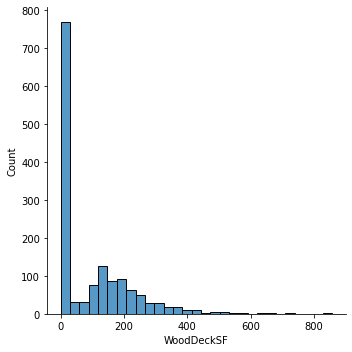

In [208]:
# WoodDeckSF
sns.displot(train_df, x = 'WoodDeckSF')

In [198]:
# HasWoodDeck
train_df['HasWoodDeck'] = np.where(train_df['WoodDeckSF'] > 0, '1', '0')

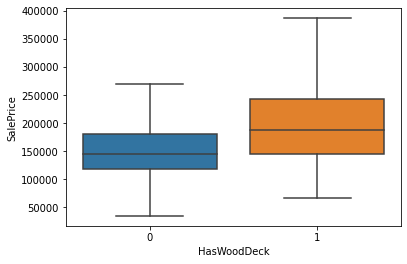

In [211]:
# HasWoodDeck
sns.boxplot(x='HasWoodDeck', y='SalePrice', data=train_df, showfliers=False)

In [199]:
train_df = train_df.drop(['WoodDeckSF'], axis = 1)

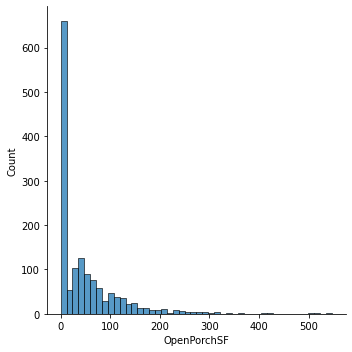

In [209]:
# OpenPorchSF
sns.displot(train_df, x = 'OpenPorchSF')

In [200]:
# HasOpenPorch
train_df['HasOpenPorch'] = np.where(train_df['OpenPorchSF'] > 0, '1', '0')

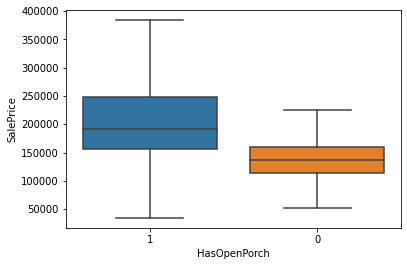

In [213]:
# HasOpenPorch
sns.boxplot(x='HasOpenPorch', y='SalePrice', data=train_df, showfliers=False)

In [201]:
train_df = train_df.drop(['OpenPorchSF'], axis = 1)

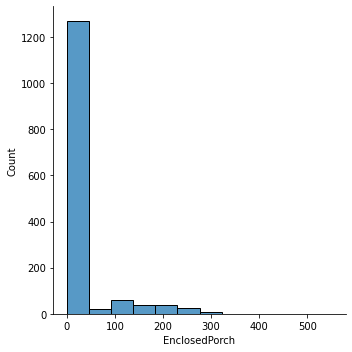

In [215]:
# EnclosedPorch
sns.displot(train_df, x = 'EnclosedPorch')

In [202]:
# HasEnclosedPorch
train_df['HasEnclosedPorch'] = np.where(train_df['EnclosedPorch'] > 0, '1', '0')

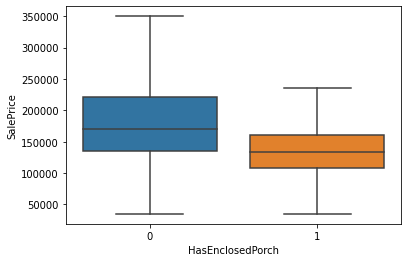

In [76]:
# HasEnclosedPorch
sns.boxplot(x='HasEnclosedPorch', y='SalePrice', data=train_df, showfliers=False)

In [203]:
train_df = train_df.drop(['EnclosedPorch'], axis = 1)

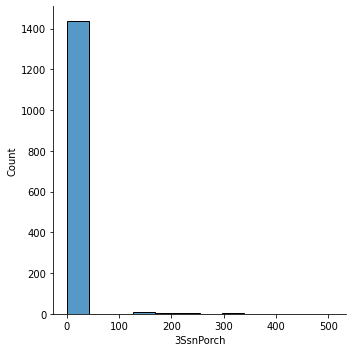

In [218]:
# 3SsnPorch
sns.displot(train_df, x = '3SsnPorch')

In [204]:
# so few homes even have a 3SsnPorch - dropping this one
train_df = train_df.drop(['3SsnPorch'], axis = 1)

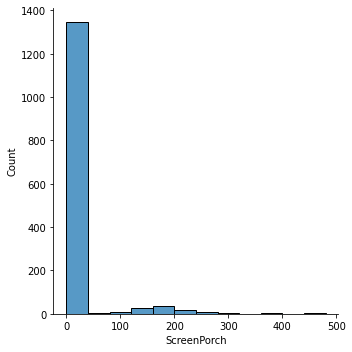

In [223]:
# ScreenPorch
sns.displot(train_df, x = 'ScreenPorch')

In [205]:
# HasScreenPorch
train_df['HasScreenPorch'] = np.where(train_df['ScreenPorch'] > 0, '1', '0')

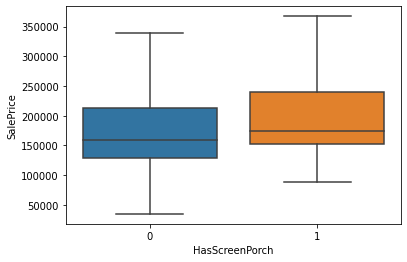

In [225]:
# HasScreenPorch
sns.boxplot(x='HasScreenPorch', y='SalePrice', data=train_df, showfliers=False)

In [221]:
train_df = train_df.drop(['ScreenPorch'], axis = 1)

For all these porch variables, is there an opportunity to create just one categorical variable that identifies whether a home has an outdoor porch space? This will depend on whether that combined categorical variable differentiates SalePrice:

In [80]:
# HasOutdoorSpace
train_df['HasOutdoorSpace'] = np.where((train_df['HasWoodDeck'] == '1') | (train_df['HasOpenPorch'] == '1') | (train_df['HasEnclosedPorch'] == '1') | (train_df['HasScreenPorch'] == '1'), '1', '0')

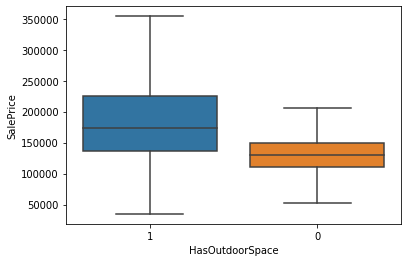

In [81]:
# HasOutdoorSpace
sns.boxplot(x='HasOutdoorSpace', y='SalePrice', data=train_df, showfliers=False)

While 'HasOutdoorSpace' does differentiate SalePrice, it does appear that individual features may have a positive or negative correlation with SalePrice. I will choose to retain the individual outdoor space features and drop the combined feature. 

In [82]:
# dropping HasOutdoorSpace
train_df = train_df.drop(['HasOutdoorSpace'], axis = 1)

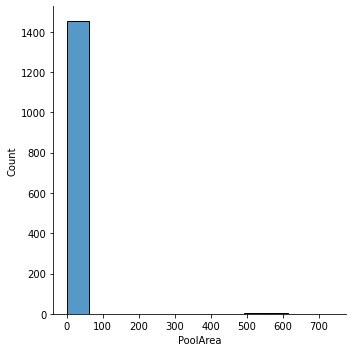

In [83]:
# PoolArea
sns.displot(train_df, x = 'PoolArea')

In [206]:
# dropping PoolArea
train_df = train_df.drop(['PoolArea'], axis = 1)

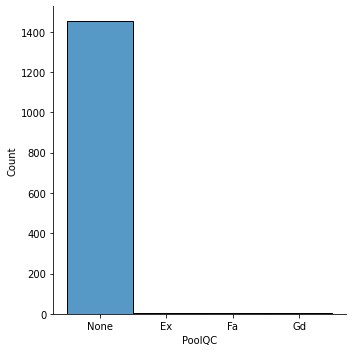

In [85]:
# PoolQC
sns.displot(train_df, x = 'PoolQC')

In [207]:
# dropping PoolQC
train_df = train_df.drop(['PoolQC'], axis = 1)

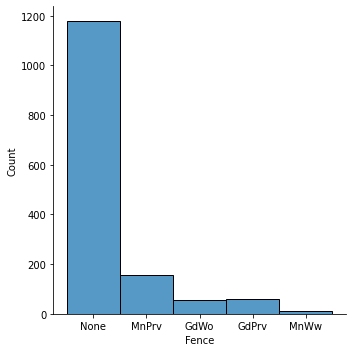

In [87]:
# Fence
sns.displot(train_df, x = 'Fence')

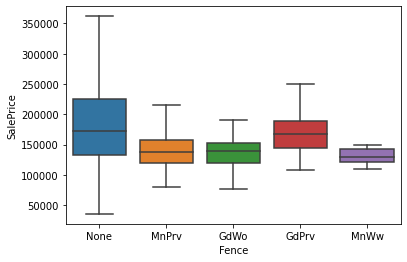

In [88]:
# Fence
sns.boxplot(x='Fence', y='SalePrice', data=train_df, showfliers=False)

In [208]:
# dropping Fence - most homes don't have one, and among those that do, it's not a great differentiator
train_df = train_df.drop(['Fence'], axis = 1)

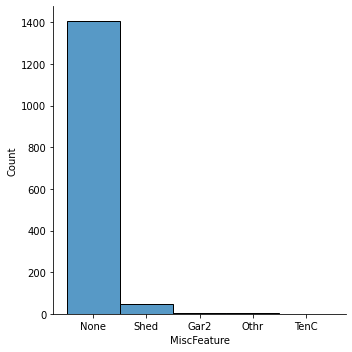

In [90]:
# MiscFeature
sns.displot(train_df, x = 'MiscFeature')

In [209]:
# dropping MiscFeature - most homes don't have one
train_df = train_df.drop(['MiscFeature'], axis = 1)
# dropping MiscVal - related
train_df = train_df.drop(['MiscVal'], axis = 1)

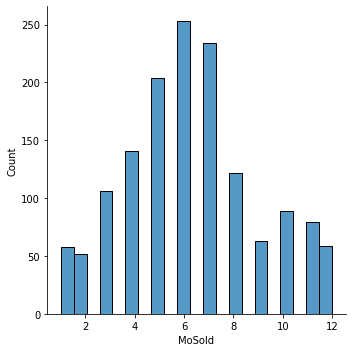

In [93]:
# MoSold
sns.displot(train_df, x = 'MoSold')

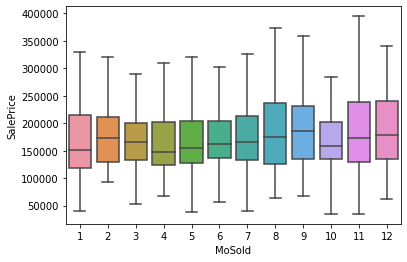

In [94]:
# MoSold
sns.boxplot(x='MoSold', y='SalePrice', data=train_df, showfliers=False)

In [210]:
# dropping MoSold - doesn't appear to differentiate SalePrice distribution
train_df = train_df.drop(['MoSold'], axis = 1)

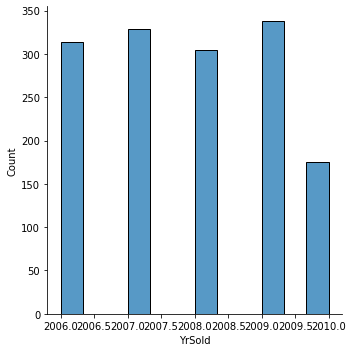

In [96]:
# YrSold
sns.displot(train_df, x = 'YrSold')

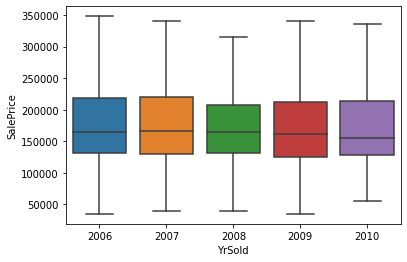

In [97]:
# YrSold
sns.boxplot(x='YrSold', y='SalePrice', data=train_df, showfliers=False)

In [211]:
# dropping YrSold - doesn't appear to differentiate SalePrice distribution
train_df = train_df.drop(['YrSold'], axis = 1)

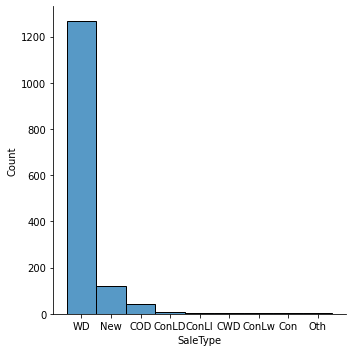

In [99]:
# SaleType
sns.displot(train_df, x = 'SaleType')

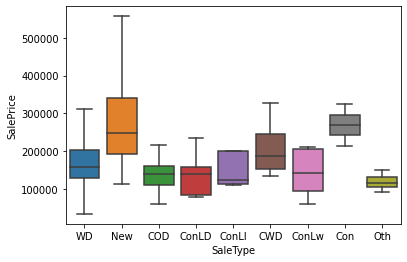

In [100]:
# SaleType
sns.boxplot(x='SaleType', y='SalePrice', data=train_df, showfliers=False)

In [212]:
# dropping SaleType - while some differentiation, very few homes outside single category
train_df = train_df.drop(['SaleType'], axis = 1)

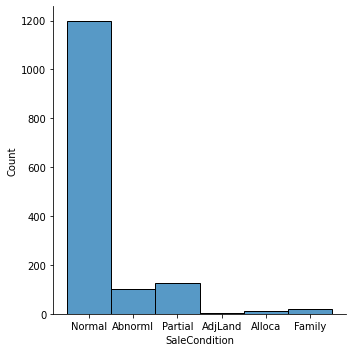

In [102]:
# SaleCondition
sns.displot(train_df, x = 'SaleCondition')

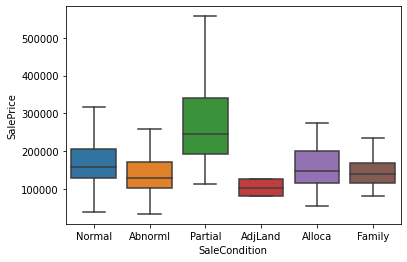

In [103]:
# SaleCondition
sns.boxplot(x='SaleCondition', y='SalePrice', data=train_df, showfliers=False)

The one category here that really differentiates SalePrice is Partial - creating new categorical variable that differentiates Partial vs. all other SaleCondition values. 

In [213]:
# PartialSale
train_df['PartialSale'] = np.where(train_df['SaleCondition'] == 'Partial', '1', '0')

In [214]:
# dropping SaleCondition
train_df = train_df.drop(['SaleCondition'], axis = 1)

In [215]:
# dropping Id - will not be used in modeling
train_df = train_df.drop(['Id'], axis = 1)

### Feature Relationships
Looking at the relationships between features that we have in our training dataset after changes complete on individual features. May further drop/alter features here.

In [222]:
train_df.head()

,MSZoning,Neighborhood,OverallQual,MasVnrType,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,GrLivArea,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,SalePrice,HasPool,HasGarage,HasBasement,HasFireplace,YearBuiltBin,NumFam,RelativeCond,LastRemod,TotalFullBath,TotRmsBin,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,HasScreenPorch,PartialSale
0,RL,CollgCr,7,BrkFace,Gd,PConc,Gd,856,Ex,Y,856,1710,Gd,None,Attchd,RFn,2,548,208500,0,1,1,0,2000-2005,Single,Above Average,Since1980,3,6-8,0,1,0,0,0
1,RL,Veenker,6,None,TA,CBlock,Gd,1262,Ex,Y,1262,1262,TA,TA,Attchd,RFn,2,460,181500,0,1,1,1,1960-79,Single,Above Average,Pre1980,2,6-8,1,0,0,0,0
2,RL,CollgCr,7,BrkFace,Gd,PConc,Gd,920,Ex,Y,920,1786,Gd,TA,Attchd,RFn,2,608,223500,0,1,1,1,2000-2005,Single,Above Average,Since1980,3,6-8,0,1,0,0,0
3,RL,Crawfor,7,None,TA,BrkTil,TA,756,Gd,Y,961,1717,Gd,Gd,Detchd,Unf,3,642,140000,0,1,1,1,pre-1960,Single,Above Average,Pre1980,2,6-8,0,1,1,0,0
4,RL,NoRidge,8,BrkFace,Gd,PConc,Gd,1145,Ex,Y,1145,2198,Gd,TA,Attchd,RFn,3,836,250000,0,1,1,1,2000-2005,Single,Above Average,Since1980,3,9 or more,1,1,0,0,0


I had initially kept the binary variables I created for each 'HasFeature', as I wasn't sure which other associated measures of that feature (if any) would remain in the final dataset. Now seeing which variables I have kept, I will need to drop those binary variables that will be perfectly correlated with a separate dummy variable (ex. 'HasFirePlace' will perfectly correltate with FireplaceQu = None'). Some of these variables will be retained (such as HasPool), as other related measures have already been dropped.

In [226]:
train_df = train_df.drop(['HasGarage'], axis = 1)
train_df = train_df.drop(['HasBasement'], axis = 1)
train_df = train_df.drop(['HasFireplace'], axis = 1)

#### **Categorical Variable Encoding**
The categorical variables within the training dataset must be processed before they can be applied in a linear regression model. One hot encoding is the process of converting a categorical variable with multiple potential values into separate dummy variables for each potential value. For each categorical variable, all but one associated dummy variable will be used in the model - we leave one value out to avoid perfect multicolinearity (the 'dummy variable trap'). 

In [227]:
categorical_vars = ['MSZoning', 'Neighborhood', 'OverallQual', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'HasPool', 'YearBuiltBin', 'NumFam', 'RelativeCond', 'LastRemod', 'TotalFullBath', 'TotRmsBin', 'HasWoodDeck', 'HasOpenPorch', 'HasEnclosedPorch', 'HasScreenPorch', 'PartialSale']

In [228]:
# encoding categorical variables as dummy variables
train_df_processed = pd.get_dummies(data=train_df, columns = categorical_vars, drop_first=True)

In [229]:
train_df_processed.head()

,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,...,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,HasPool_1,YearBuiltBin_1980-1999,YearBuiltBin_2000-2005,YearBuiltBin_2005 or later,YearBuiltBin_pre-1960,NumFam_Single,RelativeCond_Below Average,LastRemod_Since1980,TotalFullBath_1,TotalFullBath_2,TotalFullBath_3,TotalFullBath_4,TotalFullBath_6,TotRmsBin_6-8,TotRmsBin_9 or more,HasWoodDeck_1,HasOpenPorch_1,HasEnclosedPorch_1,HasScreenPorch_1,PartialSale_1
0,856,856,1710,548,208500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0
1,1262,1262,1262,460,181500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0
2,920,920,1786,608,223500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0
3,756,961,1717,642,140000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0
4,1145,1145,2198,836,250000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,1,0,0,0


# **House Price Modeling**
Now that preprocessing steps (one hot encoding categorical variables + scaling independent variable distributions) have been complete, I am ready to move into the modeling phase - looking to identify a model that best predicts SalePrice.

## Model 1

First, I'm going to attempt to predict SalePrice with a simple linear regression, looking at only 'GrLivArea' (the above-ground square footage, which we saw had a decently strong linear realtionship with SalePrice). I'm applying standard scaling to the independent variable but leaving the dependent variable unscaled.

In [274]:
# feature to look at 
features1 = ['GrLivArea']

# train test split
x1 = train_df_processed[features1]
y1 = train_df_processed['SalePrice']

print(x1.shape)
print(y1.shape)

# set seed for reproducibility
np.random.seed(100)
x1train, x1test, y1train, y1test = train_test_split(x1, y1, test_size=.2)

print(x1train.shape)
print(y1train.shape)

(1456, 1)
(1456,)
(1164, 1)
(1164,)


In [275]:
sscaler = StandardScaler()

# standard scaling on independent variable
x1train_scaled = sscaler.fit_transform(x1train)
x1test_scaled = sscaler.transform(x1test)

In [276]:
# linear regression model
linreg1 = LinearRegression()
# cross validation
cv = KFold(n_splits=7, shuffle=True)

In [283]:
# cross validation scores
cvscores = cross_val_score(linreg1, x1train_scaled, y1train, cv=cv)
print(cvscores)
print(f'Mean Score: {cvscores.mean()}')
print(f'Standard Deviation: {cvscores.std()}')

# fit linear regression to training set, predict on test (validation) set
linreg1.fit(x1train_scaled, y1train)
print(f'Train Score: {linreg1.score(x1train_scaled, y1train)}')
print(f'Test Score: {linreg1.score(x1test_scaled, y1test)}')

# generate predictions of SalePrice on test set
pred = linreg1.predict(x1test_scaled)

# fit line between actual and predicted values
b, m = np.polynomial.polynomial.polyfit(y1test, pred, 1)

[0.48833311 0.43201806 0.5393572  0.594368   0.47673919 0.47018394
 0.49787551]
Mean Score: 0.4998392857178318
Standard Deviation: 0.04876527441130417
Train Score: 0.5041523041572409
Test Score: 0.5674211166087237


Text(0.5, 1.0, 'Predicted vs. Actual Sale Price')

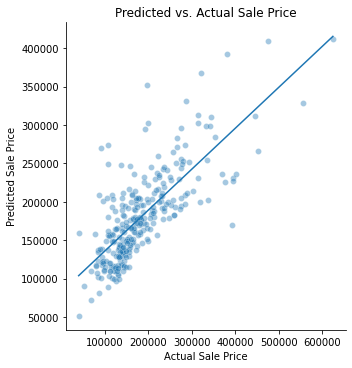

In [288]:
# visualize predictions vs. actual SalePrice values from Model 1
sns.relplot(x=y1test, y=pred, kind='scatter', alpha=0.4)
sns.lineplot(x=np.unique(y1test), y=np.unique(np.poly1d(b+m*np.unique(y1test))))


plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs. Actual Sale Price')

This model didn't perform very well - it's clear that GrLivArea alone is not a strong enough predictor of SalePrice. 

## Model 2
Moving on to predict SalePrice using Multiple Linear Regression - using a combination of the variables I had processed earlier. For this model, I am going to attempt to predict SalePrice using all of the numeric/quantitative variables from my processed dataset.

In [289]:
# features to look at 
features2 = ['TotalBsmtSF', '1stFlrSF', 'GarageArea', 'GrLivArea']

# train test split
x2 = train_df_processed[features2]
y2 = train_df_processed['SalePrice']

print(x2.shape)
print(y2.shape)

# set seed for reproducibility
np.random.seed(100)
x2train, x2test, y2train, y2test = train_test_split(x2, y2, test_size=.2)

print(x2train.shape)
print(y2train.shape)

(1456, 4)
(1456,)
(1164, 4)
(1164,)


In [290]:
sscaler = StandardScaler()

# standard scaling on independent variable
x2train_scaled = sscaler.fit_transform(x2train)
x2test_scaled = sscaler.transform(x2test)

In [291]:
# linear regression model
linreg2 = LinearRegression()
# cross validation
cv = KFold(n_splits=7, shuffle=True)

In [294]:
# cross validation scores
cvscores = cross_val_score(linreg2, x2train_scaled, y2train, cv=cv)
print(cvscores)
print(f'Mean Score: {cvscores.mean()}')
print(f'Standard Deviation: {cvscores.std()}')

# fit linear regression to training set, predict on test (validation) set
linreg2.fit(x2train_scaled, y1train)
print(f'Train Score: {linreg2.score(x2train_scaled, y2train)}')
print(f'Test Score: {linreg2.score(x2test_scaled, y2test)}')

# generate predictions of SalePrice on test set
pred = linreg2.predict(x2test_scaled)

# fit line between actual and predicted values
b, m = np.polynomial.polynomial.polyfit(y2test, pred, 1)

[0.75557004 0.73824233 0.7309031  0.68657786 0.71355475 0.75526974
 0.64891068]
Mean Score: 0.7184326412330376
Standard Deviation: 0.03616611990848487
Train Score: 0.7253463242896387
Test Score: 0.7182327022408072


Text(0.5, 1.0, 'Predicted vs. Actual Sale Price')

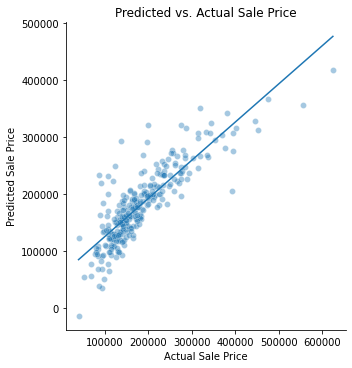

In [295]:
# visualize predictions vs. actual SalePrice values from Model 2
sns.relplot(x=y2test, y=pred, kind='scatter', alpha=0.4)
sns.lineplot(x=np.unique(y2test), y=np.unique(np.poly1d(b+m*np.unique(y2test))))


plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs. Actual Sale Price')

This model offered decent improvement over Model 1 - clearly, the addition of the remaining quantitative variables results in an improvement in the model's prediction ability.

## Model 3 

While a better practice may be to add categorical variables one-by-one in order to quantify the influence of each variable on the model, I am going to go ahead and add several variables that - based on my exploratory analysis - I expect to have a strong predictive value. 

In [305]:
df_model3 = ['SalePrice', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'GrLivArea', 'Neighborhood', 'OverallQual', 'BsmtQual', 'KitchenQual', 'GarageType', 'YearBuiltBin', 'NumFam', 'RelativeCond', 'TotalFullBath', 'TotRmsBin']

In [303]:
categorical_vars_model3 = ['Neighborhood', 'OverallQual', 'BsmtQual', 'KitchenQual', 'GarageType', 'YearBuiltBin', 'NumFam', 'RelativeCond', 'TotalFullBath', 'TotRmsBin']

In [306]:
# encoding categorical variables as dummy variables
df_model3 = pd.get_dummies(data=train_df[df_model3], columns = categorical_vars_model3, drop_first=True)

In [308]:
# train test split
x3 = df_model3.drop(['SalePrice'], axis = 1)
y3 = df_model3['SalePrice']

print(x3.shape)
print(y3.shape)

# set seed for reproducibility
np.random.seed(100)
x3train, x3test, y3train, y3test = train_test_split(x3, y3, test_size=.2)

print(x3train.shape)
print(y3train.shape)

(1456, 63)
(1456,)
(1164, 63)
(1164,)


In [342]:
sscaler = StandardScaler()

# standard scaling on independent variable
x3train_scaled = sscaler.fit_transform(x3train)
x3test_scaled = sscaler.transform(x3test)

In [310]:
# linear regression model
linreg3 = LinearRegression()
# cross validation
cv = KFold(n_splits=7, shuffle=True)

In [311]:
# cross validation scores
cvscores = cross_val_score(linreg3, x3train_scaled, y3train, cv=cv)
print(cvscores)
print(f'Mean Score: {cvscores.mean()}')
print(f'Standard Deviation: {cvscores.std()}')

# fit linear regression to training set, predict on test (validation) set
linreg3.fit(x3train_scaled, y1train)
print(f'Train Score: {linreg3.score(x3train_scaled, y3train)}')
print(f'Test Score: {linreg3.score(x3test_scaled, y3test)}')

# generate predictions of SalePrice on test set
pred = linreg3.predict(x3test_scaled)

# fit line between actual and predicted values
b, m = np.polynomial.polynomial.polyfit(y3test, pred, 1)

[ 8.69450626e-01  6.19157957e-01  8.64476553e-01 -5.82164676e+21
  8.39493234e-01  9.04222558e-01  8.79766149e-01]
Mean Score: -8.316638230627503e+20
Standard Deviation: 2.0371520040360508e+21
Train Score: 0.8971294236113405
Test Score: 0.8878274327713312


Text(0.5, 1.0, 'Predicted vs. Actual Sale Price')

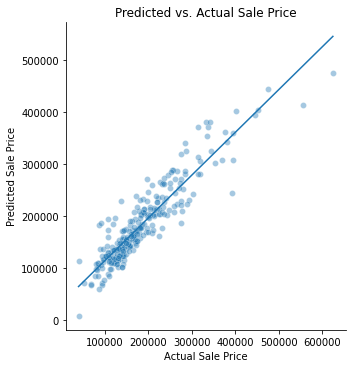

In [319]:
# visualize predictions vs. actual SalePrice values from Model 3
sns.relplot(x=y3test, y=pred, kind='scatter', alpha=0.4)
sns.lineplot(x=np.unique(y3test), y=np.unique(np.poly1d(b+m*np.unique(y3test))))


plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs. Actual Sale Price')

This model, with some categorical variables included, performed better than the model trained on quantitative variables alone. I will apply this model to the Kaggle competition test data for submission.

# Generating final test set predictions

In [320]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [321]:
test_df = pd.read_csv('test.csv')

test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## apply transformations to test data

In [361]:
test_df.PoolQC.fillna('None', inplace=True)
test_df.MiscFeature.fillna('None', inplace=True)
test_df.Alley.fillna('None', inplace=True)
test_df.Fence.fillna('None', inplace=True)
test_df.FireplaceQu.fillna('None', inplace=True)
test_df.GarageCond.fillna('None', inplace=True)
test_df.GarageType.fillna('None', inplace=True)
test_df.GarageYrBlt.fillna('None', inplace=True)
test_df.GarageFinish.fillna('None', inplace=True)
test_df.GarageQual.fillna('None', inplace=True)
test_df.BsmtExposure.fillna('None', inplace=True)
test_df.BsmtFinType2.fillna('None', inplace=True)
test_df.BsmtFinType1.fillna('None', inplace=True)
test_df.BsmtCond.fillna('None', inplace=True)
test_df.BsmtQual.fillna('None', inplace=True)
test_df.MasVnrType.fillna('None', inplace=True)
test_df.GarageArea.fillna(0, inplace=True)
test_df.TotalBsmtSF.fillna(0, inplace=True)


In [323]:
# replace Electrical = NA with most common Electrical value
test_df.Electrical.fillna(test_df.Electrical.mode()[0], inplace=True)

In [324]:
# replace LotFrontage = NA with median LotFrontage for associated Neighborhood
test_df.LotFrontage = test_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [325]:
test_df.MasVnrArea.fillna(0, inplace=True)

In [329]:
# yearbuiltbin
test_df['YearBuiltBin'] = test_df['YearBuilt'].apply(get_year_built_bin)

In [328]:
# new variable: NumFam
test_df['NumFam'] = np.where((test_df['BldgType'] == '2fmCon') | (test_df['BldgType'] == 'Duplex'), 'Multi', 'Single')

In [330]:
# new variable: RelativeCond
test_df['RelativeCond'] = np.where(test_df['OverallCond'] >= 5, 'Above Average', 'Below Average')

In [331]:
# new variable - total full baths
test_df['TotalFullBath'] = test_df['FullBath'] + test_df['BsmtFullBath'] 

In [351]:
# replace TotalFullBath = NA with median TotalFullBath for associated Neighborhood
test_df.TotalFullBath = test_df.groupby('Neighborhood')['TotalFullBath'].transform(lambda x: x.fillna(x.median()))

In [332]:
# new variable - TotRmsBin
test_df['TotRmsBin'] = test_df['TotRmsAbvGrd'].apply(get_rooms_bin)

In [358]:
# replace KitchenQual = NA with most common KitchenQual value
test_df.KitchenQual.fillna(test_df.KitchenQual.mode()[0], inplace=True)

In [337]:
cols_to_keep = ['Id', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'GrLivArea', 'Neighborhood', 'OverallQual', 'BsmtQual', 'KitchenQual', 'GarageType', 'YearBuiltBin', 'NumFam', 'RelativeCond', 'TotalFullBath', 'TotRmsBin']

In [363]:
test_df_updated = test_df[cols_to_keep]

In [364]:
# confirm that all NA values have been addressed
# get counts of NA values
ct_na = test_df_updated.isna().sum().sort_values(ascending=False)
ct_na[ct_na > 0]

Series([], dtype: int64)

## apply model 2 to test data

In [380]:
# filter test_df to include only features used in model 2
test_df2 = test_df_updated[features2]

In [381]:
# apply scaling to test dataset
sscaler = StandardScaler()

test_scaled2 = sscaler.fit_transform(test_df2)

In [382]:
# predict saleprice for test dataset

pred = linreg2.predict(test_scaled2)
final_predictions2 = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': pred})

print(final_predictions2)

        Id      SalePrice
0     1461  155022.835684
1     1462  169310.694687
2     1463  185540.501987
3     1464  182473.053494
4     1465  182191.092631
...    ...            ...
1454  2915   79193.525990
1455  2916  107259.869037
1456  2917  182023.207607
1457  2918   89872.225630
1458  2919  232157.851474

[1459 rows x 2 columns]


In [383]:
# export final predictions
final_predictions2.to_csv('final_predictions2.csv', index=False)

files.download('final_predictions2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

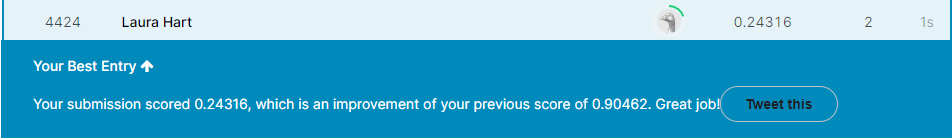

Model 2 performed significantly better than Model 3 - in this case with Linear Regression, the effort to engineer categorical features is not worth the variance that those features add to the model.

## apply model 3 to test data

In [365]:
# encoding categorical variables as dummy variables
test_df_encoded = pd.get_dummies(data=test_df_updated, columns = categorical_vars_model3, drop_first=True)

In [366]:
test_df_encoded.head()

,Id,TotalBsmtSF,1stFlrSF,GarageArea,GrLivArea,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,YearBuiltBin_1980-1999,YearBuiltBin_2000-2005,YearBuiltBin_2005 or later,YearBuiltBin_pre-1960,NumFam_Single,RelativeCond_Below Average,TotalFullBath_2.0,TotalFullBath_3.0,TotalFullBath_4.0,TotalFullBath_6.0,TotRmsBin_6-8,TotRmsBin_9 or more
0,1461,882.0,896,730.0,896,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1462,1329.0,1329,312.0,1329,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
2,1463,928.0,928,482.0,1629,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
3,1464,926.0,926,470.0,1604,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
4,1465,1280.0,1280,506.0,1280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0


In [367]:
# apply scaling to test dataset
sscaler = StandardScaler()

test_scaled = sscaler.fit_transform(test_df_encoded)

In [369]:
# predict saleprice for test dataset

pred = linreg3.predict(test_scaled)
final_predictions = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': pred})

print(final_predictions)

        Id      SalePrice
0     1461  159541.088788
1     1462   83914.152559
2     1463  151760.113549
3     1464   98884.638670
4     1465  162547.213223
...    ...            ...
1454  2915  105962.677861
1455  2916  285480.444076
1456  2917  230406.864738
1457  2918  127578.876945
1458  2919  249794.236291

[1459 rows x 2 columns]


In [379]:
# export final predictions
final_predictions.to_csv('final_predictions.csv', index=False)

files.download('final_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>